

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-08-18 19:44:31,929: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json


In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(5000, 32, 32, 3) (5000,)
(10000, 32, 32, 3) (10000,)


In [24]:
def save_images(image_folder_path, images, labels):
    i = 0    
    if not os.path.exists(image_folder_path):
        os.makedirs(image_folder_path)
    for train_image, train_label  in zip(images, labels):
        i = i + 1
        image = Image.fromarray(train_image)
        image_path = os.path.join(image_folder_path, f"{i}.png")
        image.save(image_path)  
    print(f'save images to {image_path}')
        


In [ ]:
image_folder_path = os.path.join(params.data_path, 'data', f'image_{params.train_image_count}')
save_images(image_folder_path, train_images, train_labels)

In [25]:
image_folder_path = os.path.join(params.data_path, 'data', f'cifar10_test_{len(test_images)}')
save_images(image_folder_path, test_images, test_labels)

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7.png
save images to /tf/e

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/257.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/258.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/259.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/260.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/261.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/262.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/263.png
save i

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/525.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/526.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/527.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/528.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/529.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/530.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/531.png
save i

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/794.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/795.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/796.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/797.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/798.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/799.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/800.png
save i

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1063.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1064.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1065.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1066.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1067.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1068.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1069.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1323.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1324.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1325.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1326.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1327.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1328.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1329.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1554.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1555.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1556.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1557.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1558.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1559.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1560.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1814.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1815.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1816.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1817.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1818.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1819.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/1820.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2083.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2084.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2085.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2086.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2087.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2088.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2089.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2351.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2352.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2353.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2354.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2355.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2356.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2357.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2620.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2621.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2622.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2623.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2624.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2625.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2626.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2892.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2893.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2894.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2895.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2896.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2897.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/2898.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3142.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3143.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3144.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3145.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3146.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3147.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3148.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3374.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3375.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3376.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3377.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3378.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3379.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3380.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3606.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3607.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3608.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3609.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3610.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3611.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3612.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3838.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3839.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3840.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3841.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3842.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3843.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/3844.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4073.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4074.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4075.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4076.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4077.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4078.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4079.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4339.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4340.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4341.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4342.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4343.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4344.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4345.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4607.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4608.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4609.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4610.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4611.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4612.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4613.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4877.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4878.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4879.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4880.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4881.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4882.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/4883.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5147.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5148.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5149.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5150.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5151.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5152.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5153.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5418.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5419.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5420.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5421.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5422.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5423.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5424.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5687.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5688.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5689.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5690.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5691.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5692.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5693.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5955.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5956.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5957.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5958.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5959.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5960.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/5961.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6224.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6225.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6226.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6227.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6228.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6229.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6230.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6492.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6493.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6494.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6495.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6496.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6497.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6498.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6763.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6764.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6765.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6766.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6767.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6768.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/6769.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7035.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7036.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7037.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7038.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7039.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7040.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7041.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7323.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7324.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7325.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7326.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7327.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7328.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7329.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7631.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7632.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7633.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7634.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7635.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7636.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7637.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7928.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7929.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7930.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7931.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7932.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7933.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/7934.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8240.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8241.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8242.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8243.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8244.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8245.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8246.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8551.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8552.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8553.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8554.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8555.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8556.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8557.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8874.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8875.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8876.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8877.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8878.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8879.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/8880.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9190.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9191.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9192.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9193.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9194.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9195.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9196.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9509.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9510.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9511.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9512.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9513.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9514.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9515.png

save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9808.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9809.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9810.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9811.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9812.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9813.png
save images to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/data/cifar10_test_10000/9814.png

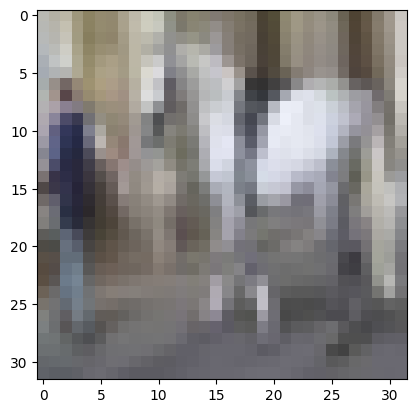

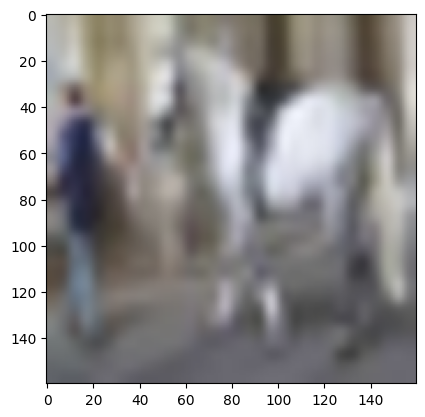

(32, 32, 3) (160, 160, 3)


In [9]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [10]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

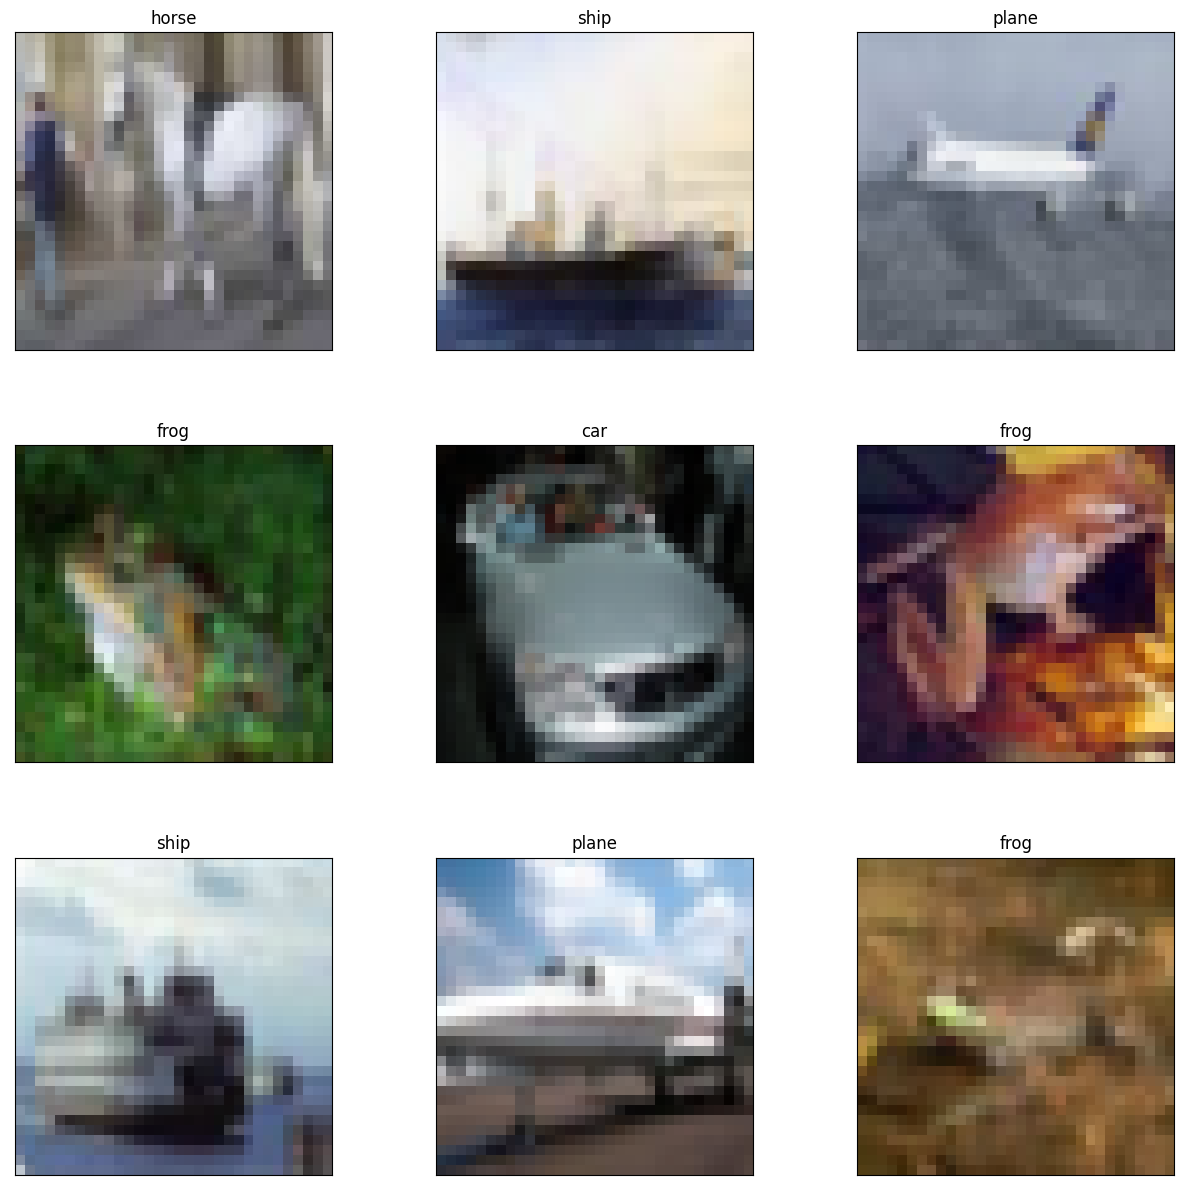

In [11]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

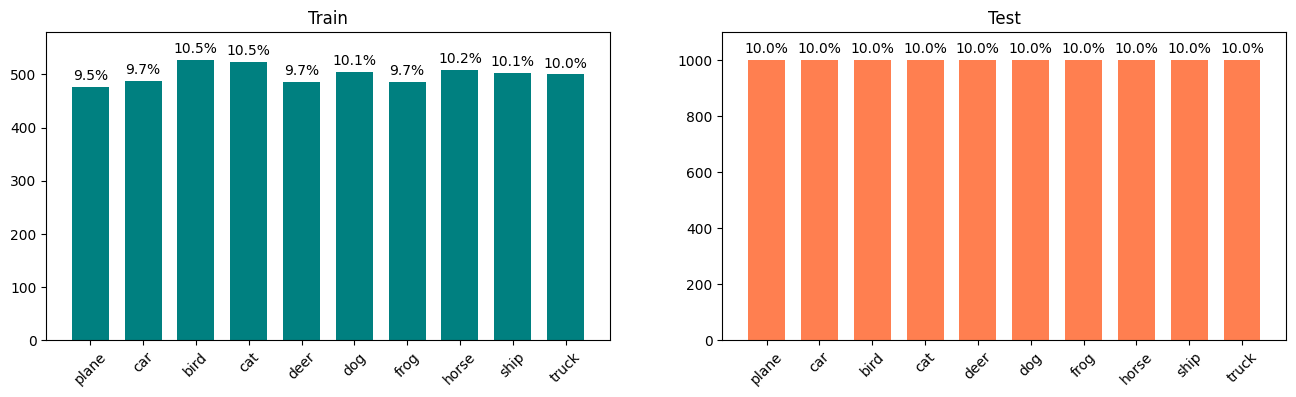

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [13]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [14]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [15]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

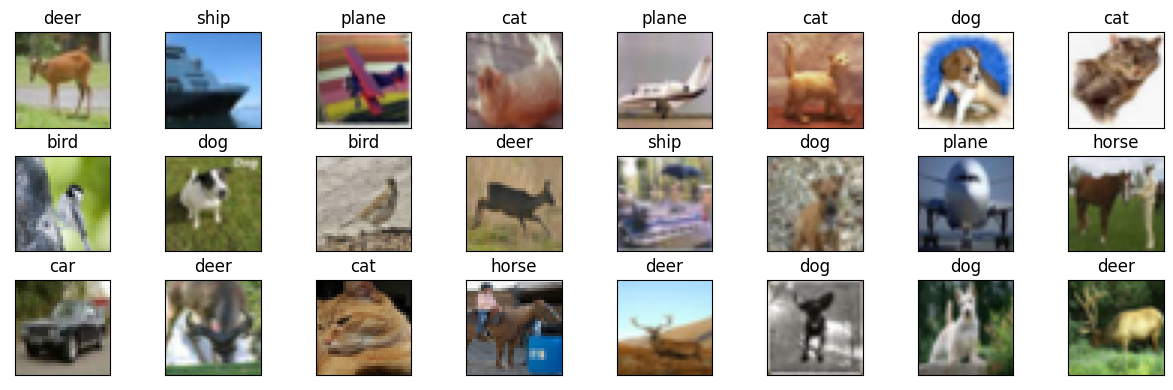

In [16]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [17]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

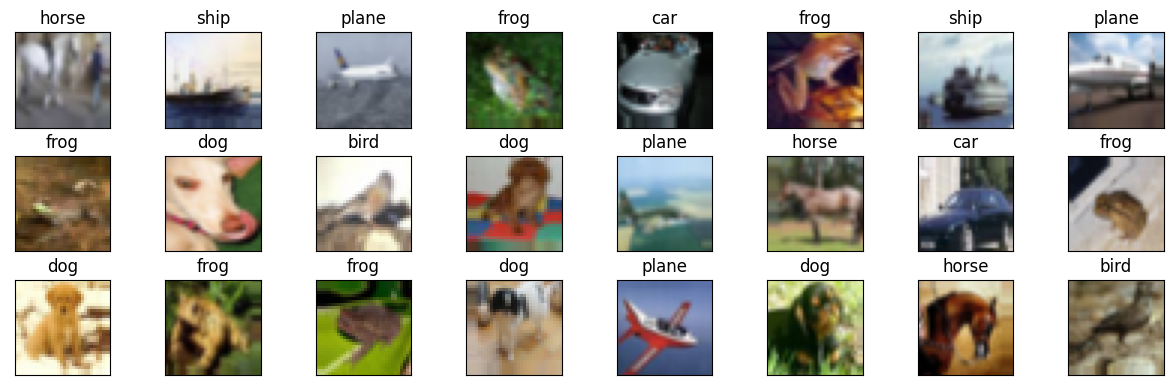

In [18]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

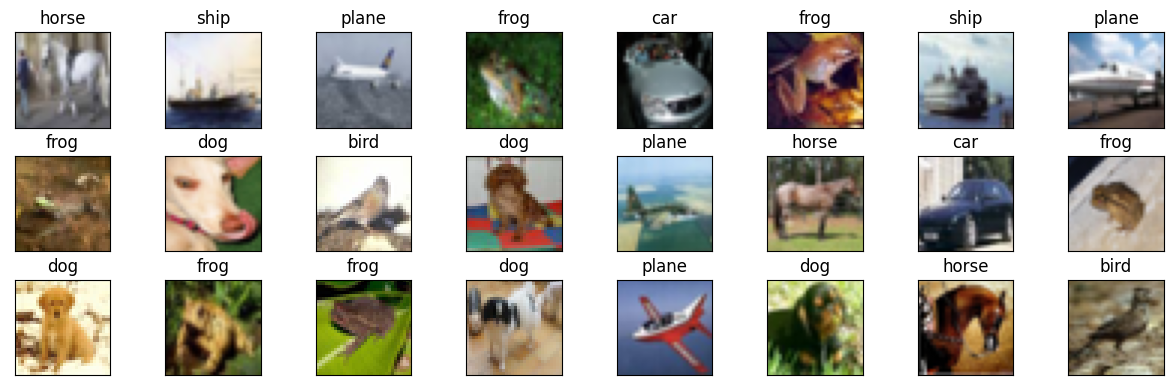

In [19]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [20]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [21]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


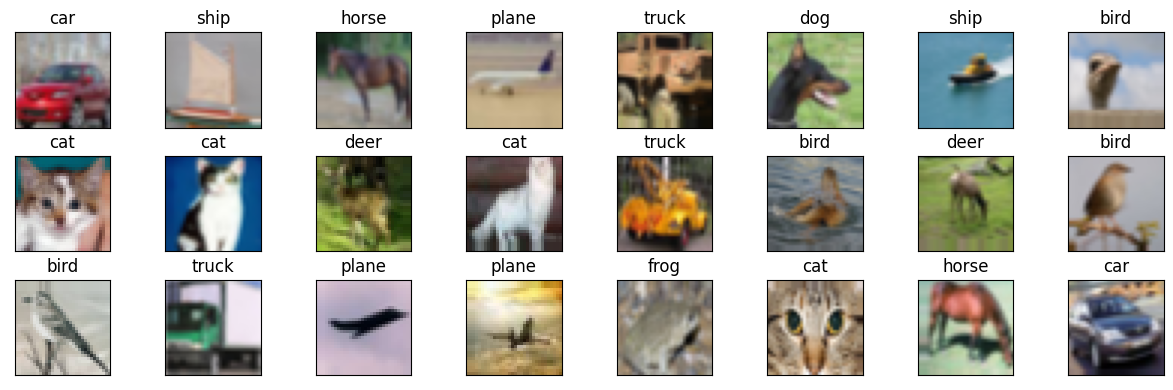

In [22]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [22]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### MLP

2022-08-16 08:53:21,122: INFO: model_params.mlp1.dropout=0.1
2022-08-16 08:53:21,123: INFO: model_params.mlp1.layer_count=1
2022-08-16 08:53:21,124: INFO: model_params.mlp1.units=128
2022-08-16 08:53:21,167: INFO: learning_rate=0.001
2022-08-16 08:53:21,168: INFO: model_params.mlp1.clip_value=None
2022-08-16 08:53:21,177: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-08-16 08:53:21,191: INFO: model_params.mlp1.epochs=90
2022-08-16 08:53:21,192: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1, monitor=val_accuracy)
2022-08-16 08:53:21,192: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:53:21,193: INFO: use LearningRateScheduler()
2022-08-16 08:53:21,194: INFO: steps_per_epoch=156
2022-08-16 08:53:21,195: INFO: start training
2022-08-16 08:53:21,196: INFO: use_class_weight=False


Epoch 1/90
149/156 [===========================>..] - ETA: 0s - loss: 2.1732 - accuracy: 0.1965INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:23,844: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 3s 12ms/step - loss: 2.1714 - accuracy: 0.1941 - val_loss: 2.0106 - val_accuracy: 0.2562 - lr: 0.0010
Epoch 2/90
156/156 [==============================] - ETA: 0s - loss: 2.0268 - accuracy: 0.2444INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:25,456: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 2.0268 - accuracy: 0.2444 - val_loss: 2.0444 - val_accuracy: 0.2574 - lr: 0.0010
Epoch 3/90
156/156 [==============================] - ETA: 0s - loss: 1.9695 - accuracy: 0.2802INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:27,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.9695 - accuracy: 0.2802 - val_loss: 1.9589 - val_accuracy: 0.2970 - lr: 0.0010
Epoch 4/90
134/156 [========================>.....] - ETA: 0s - loss: 1.9145 - accuracy: 0.3053INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:28,686: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.9209 - accuracy: 0.3013 - val_loss: 1.9268 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 5/90
153/156 [============================>.] - ETA: 0s - loss: 1.9081 - accuracy: 0.3035INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:30,458: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 11ms/step - loss: 1.9065 - accuracy: 0.3055 - val_loss: 1.8913 - val_accuracy: 0.3292 - lr: 0.0010
Epoch 6/90
155/156 [============================>.] - ETA: 0s - loss: 1.8894 - accuracy: 0.3145INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:32,138: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 11ms/step - loss: 1.8890 - accuracy: 0.3145 - val_loss: 1.8564 - val_accuracy: 0.3391 - lr: 0.0010
Epoch 7/90
156/156 [==============================] - 1s 6ms/step - loss: 1.8592 - accuracy: 0.3237 - val_loss: 1.8531 - val_accuracy: 0.3269 - lr: 0.0010
Epoch 8/90
156/156 [==============================] - 1s 6ms/step - loss: 1.8377 - accuracy: 0.3287 - val_loss: 1.8651 - val_accuracy: 0.3365 - lr: 0.0010
Epoch 9/90
155/156 [============================>.] - ETA: 0s - loss: 1.8170 - accuracy: 0.3403INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:35,978: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 12ms/step - loss: 1.8173 - accuracy: 0.3397 - val_loss: 1.8454 - val_accuracy: 0.3405 - lr: 0.0010
Epoch 10/90
156/156 [==============================] - 1s 6ms/step - loss: 1.8128 - accuracy: 0.3357 - val_loss: 1.8471 - val_accuracy: 0.3361 - lr: 0.0010
Epoch 11/90
138/156 [=========================>....] - ETA: 0s - loss: 1.7799 - accuracy: 0.3571INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:38,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.7859 - accuracy: 0.3542 - val_loss: 1.8169 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 12/90
156/156 [==============================] - 1s 6ms/step - loss: 1.7688 - accuracy: 0.3542 - val_loss: 1.8335 - val_accuracy: 0.3488 - lr: 0.0010
Epoch 13/90
156/156 [==============================] - 1s 6ms/step - loss: 1.7557 - accuracy: 0.3622 - val_loss: 1.8614 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 14/90
156/156 [==============================] - 1s 6ms/step - loss: 1.7527 - accuracy: 0.3676 - val_loss: 1.8289 - val_accuracy: 0.3433 - lr: 0.0010
Epoch 15/90
139/156 [=========================>....] - ETA: 0s - loss: 1.7330 - accuracy: 0.3730INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:43,024: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.7412 - accuracy: 0.3662 - val_loss: 1.8037 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 16/90
151/156 [============================>.] - ETA: 0s - loss: 1.7194 - accuracy: 0.3717INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:44,673: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 11ms/step - loss: 1.7189 - accuracy: 0.3712 - val_loss: 1.8023 - val_accuracy: 0.3597 - lr: 0.0010
Epoch 17/90
156/156 [==============================] - 1s 6ms/step - loss: 1.7148 - accuracy: 0.3806 - val_loss: 1.8110 - val_accuracy: 0.3524 - lr: 0.0010
Epoch 18/90
138/156 [=========================>....] - ETA: 0s - loss: 1.6979 - accuracy: 0.3877INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:47,227: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.7024 - accuracy: 0.3834 - val_loss: 1.7933 - val_accuracy: 0.3637 - lr: 0.0010
Epoch 19/90
156/156 [==============================] - 1s 6ms/step - loss: 1.6985 - accuracy: 0.3854 - val_loss: 1.7984 - val_accuracy: 0.3587 - lr: 0.0010
Epoch 20/90
156/156 [==============================] - 1s 6ms/step - loss: 1.6743 - accuracy: 0.3892 - val_loss: 1.7846 - val_accuracy: 0.3588 - lr: 0.0010
Epoch 21/90
136/156 [=========================>....] - ETA: 0s - loss: 1.6708 - accuracy: 0.3938INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:50,772: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.6752 - accuracy: 0.3900 - val_loss: 1.7804 - val_accuracy: 0.3677 - lr: 0.0010
Epoch 22/90
135/156 [========================>.....] - ETA: 0s - loss: 1.6598 - accuracy: 0.4007INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:53:52,388: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.6672 - accuracy: 0.3946 - val_loss: 1.7730 - val_accuracy: 0.3687 - lr: 0.0010
Epoch 23/90
156/156 [==============================] - 1s 6ms/step - loss: 1.6561 - accuracy: 0.3990 - val_loss: 1.8235 - val_accuracy: 0.3522 - lr: 0.0010
Epoch 24/90
156/156 [==============================] - 1s 6ms/step - loss: 1.6427 - accuracy: 0.4060 - val_loss: 1.8096 - val_accuracy: 0.3547 - lr: 0.0010
Epoch 25/90
156/156 [==============================] - 1s 6ms/step - loss: 1.6422 - accuracy: 0.4101 - val_loss: 1.7889 - val_accuracy: 0.3624 - lr: 0.0010
Epoch 26/90
156/156 [==============================] - 1s 6ms/step - loss: 1.6486 - accuracy: 0.4018 - val_loss: 1.8011 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 27/90
156/156 [==============================] - 1s 6ms/step - loss: 1.6326 - accuracy: 0.4060 - val_loss: 1.8097 - val_accuracy: 0.3524 - lr: 0.0010
Epoch 28/90
156/156 [==============================] - 1s 6ms/step - loss: 

2022-08-16 08:54:03,511: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.5866 - accuracy: 0.4279 - val_loss: 1.7787 - val_accuracy: 0.3724 - lr: 0.0010
Epoch 34/90
156/156 [==============================] - 1s 6ms/step - loss: 1.5760 - accuracy: 0.4249 - val_loss: 1.7900 - val_accuracy: 0.3647 - lr: 0.0010
Epoch 35/90
156/156 [==============================] - 1s 6ms/step - loss: 1.5724 - accuracy: 0.4381 - val_loss: 1.8188 - val_accuracy: 0.3551 - lr: 0.0010
Epoch 36/90
156/156 [==============================] - 1s 6ms/step - loss: 1.5529 - accuracy: 0.4419 - val_loss: 1.7959 - val_accuracy: 0.3689 - lr: 0.0010
Epoch 37/90
147/156 [===========================>..] - ETA: 0s - loss: 1.5525 - accuracy: 0.4343INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:08,219: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
156/156 [==============================] - 2s 12ms/step - loss: 1.5536 - accuracy: 0.4327 - val_loss: 1.7884 - val_accuracy: 0.3730 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
156/156 [==============================] - 1s 6ms/step - loss: 1.5330 - accuracy: 0.4395 - val_loss: 1.8147 - val_accuracy: 0.3622 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
156/156 [==============================] - 1s 6ms/step - loss: 1.5029 - accuracy: 0.4615 - val_loss: 1.8251 - val_accuracy: 0.3513 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
156/156 [==============================] - 1s 6ms/step - loss: 1.5035 - accuracy: 0.4583 - val_loss: 1.8308 - val_accuracy: 0.3558 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
156/156 [===========

2022-08-16 08:54:24,171: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4476 - accuracy: 0.4748 - val_loss: 1.7786 - val_accuracy: 0.3739 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/90
153/156 [============================>.] - ETA: 0s - loss: 1.4412 - accuracy: 0.4767INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:25,780: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4444 - accuracy: 0.4756 - val_loss: 1.7750 - val_accuracy: 0.3754 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4409 - accuracy: 0.4788 - val_loss: 1.7774 - val_accuracy: 0.3749 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/90
135/156 [========================>.....] - ETA: 0s - loss: 1.4166 - accuracy: 0.4859INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:28,354: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4259 - accuracy: 0.4834 - val_loss: 1.7750 - val_accuracy: 0.3783 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4359 - accuracy: 0.4796 - val_loss: 1.7784 - val_accuracy: 0.3772 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/90
156/156 [==============================] - ETA: 0s - loss: 1.4398 - accuracy: 0.4770INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:30,893: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4398 - accuracy: 0.4770 - val_loss: 1.7744 - val_accuracy: 0.3790 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4285 - accuracy: 0.4786 - val_loss: 1.7766 - val_accuracy: 0.3789 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
155/156 [============================>.] - ETA: 0s - loss: 1.4341 - accuracy: 0.4770INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:33,456: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4337 - accuracy: 0.4776 - val_loss: 1.7768 - val_accuracy: 0.3791 - lr: 1.0000e-04
Epoch 61/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4473 - accuracy: 0.4750 - val_loss: 1.7769 - val_accuracy: 0.3774 - lr: 1.0000e-04
Epoch 62/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4282 - accuracy: 0.4760 - val_loss: 1.7742 - val_accuracy: 0.3787 - lr: 1.0000e-04
Epoch 63/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4258 - accuracy: 0.4860 - val_loss: 1.7814 - val_accuracy: 0.3766 - lr: 1.0000e-04
Epoch 64/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4277 - accuracy: 0.4868 - val_loss: 1.7770 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 65/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4117 - accuracy: 0.4836 - val_loss: 1.7765 - val_accuracy: 0.3777 - lr: 1.0000e-04
Epoch 66/90
156/156 [==============================

2022-08-16 08:54:41,722: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4144 - accuracy: 0.4888 - val_loss: 1.7749 - val_accuracy: 0.3809 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/90
153/156 [============================>.] - ETA: 0s - loss: 1.4102 - accuracy: 0.4839INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:43,354: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4092 - accuracy: 0.4842 - val_loss: 1.7756 - val_accuracy: 0.3810 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
155/156 [============================>.] - ETA: 0s - loss: 1.4037 - accuracy: 0.4974INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:44,946: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4032 - accuracy: 0.4986 - val_loss: 1.7750 - val_accuracy: 0.3817 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4076 - accuracy: 0.4896 - val_loss: 1.7769 - val_accuracy: 0.3815 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4152 - accuracy: 0.4868 - val_loss: 1.7753 - val_accuracy: 0.3813 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
134/156 [========================>.....] - ETA: 0s - loss: 1.3942 - accuracy: 0.4977INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:48,466: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4081 - accuracy: 0.4902 - val_loss: 1.7757 - val_accuracy: 0.3820 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4078 - accuracy: 0.4864 - val_loss: 1.7769 - val_accuracy: 0.3808 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4129 - accuracy: 0.4934 - val_loss: 1.7769 - val_accuracy: 0.3819 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
137/156 [=========================>....] - ETA: 0s - loss: 1.4025 - accuracy: 0.4945INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


2022-08-16 08:54:52,037: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4120 - accuracy: 0.4914 - val_loss: 1.7759 - val_accuracy: 0.3826 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4099 - accuracy: 0.4860 - val_loss: 1.7762 - val_accuracy: 0.3815 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4058 - accuracy: 0.4890 - val_loss: 1.7766 - val_accuracy: 0.3810 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4154 - accuracy: 0.4912 - val_loss: 1.7755 - val_accuracy: 0.3804 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/90
156/156 [==============================] - 1s 6ms/step - loss: 1.4121 - accuracy: 0.4900 - val_loss

2022-08-16 08:55:04,832: INFO: finish training [elapsed time: 103.64 seconds]


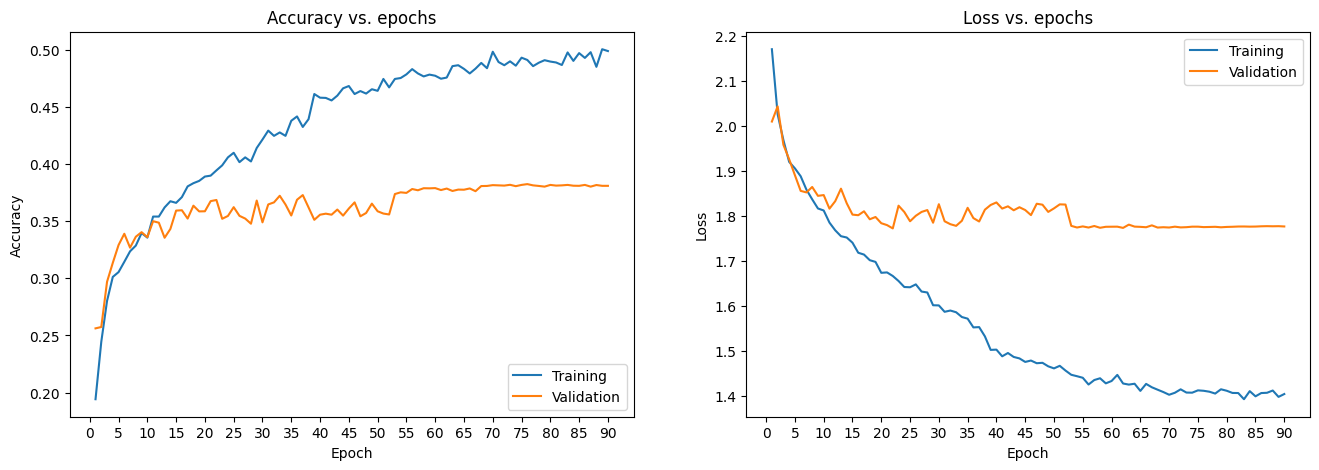

2022-08-16 08:55:05,257: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-08-16 08:55:08,230: INFO: test loss:1.7759
2022-08-16 08:55:08,230: INFO: test accuracy:0.3826
2022-08-16 08:55:08,231: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 08:55:08,233: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 08:55:08,233: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 08:55:08,235: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 0s 1ms/step


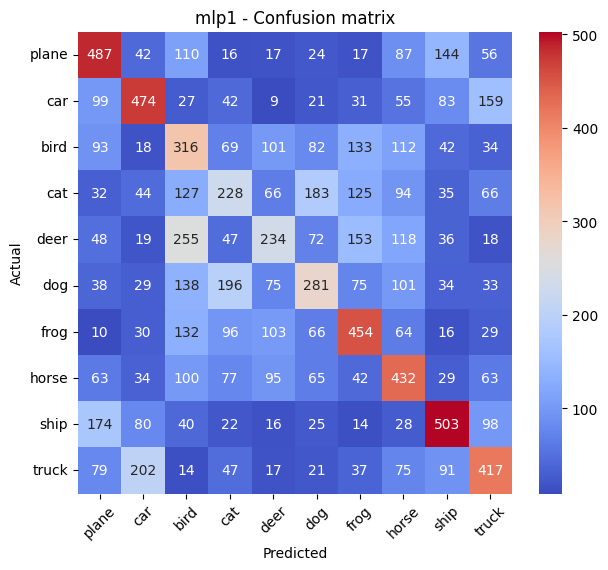

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1       mlp1  cifar10_0816_cnt_500.ipynb         394634       103.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:55      1.3138     1.7759          0.5434         0.3826   

   train_auc  test_auc  
1     0.9025    0.8128

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 08:55:09,624: INFO: model_params.lenet1.dropout=0.2
2022-08-16 08:55:09,712: INFO: learning_rate=0.001
2022-08-16 08:55:09,713: INFO: model_params.lenet1.clip_value=None
2022-08-16 08:55:09,718: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0    

2022-08-16 08:55:09,747: INFO: model_params.lenet1.epochs=90
2022-08-16 08:55:09,748: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1, monitor=val_accuracy)
2022-08-16 08:55:09,748: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:55:09,749: INFO: use LearningRateScheduler()
2022-08-16 08:55:09,750: INFO: steps_per_epoch=156
2022-08-16 08:55:09,750: INFO: start training
2022-08-16 08:55:09,751: INFO: use_class_weight=False


Epoch 1/90
149/156 [===========================>..] - ETA: 0s - loss: 2.2073 - accuracy: 0.2244

2022-08-16 08:55:14,178: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:14,748: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 5s 22ms/step - loss: 2.1963 - accuracy: 0.2262 - val_loss: 2.0989 - val_accuracy: 0.1952 - lr: 0.0010
Epoch 2/90
151/156 [============================>.] - ETA: 0s - loss: 1.9087 - accuracy: 0.3098

2022-08-16 08:55:17,608: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:18,167: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 1.9052 - accuracy: 0.3111 - val_loss: 2.0864 - val_accuracy: 0.2560 - lr: 0.0010
Epoch 3/90
154/156 [============================>.] - ETA: 0s - loss: 1.7655 - accuracy: 0.3604

2022-08-16 08:55:20,680: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:21,249: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 20ms/step - loss: 1.7652 - accuracy: 0.3600 - val_loss: 1.7437 - val_accuracy: 0.3682 - lr: 0.0010
Epoch 4/90
151/156 [============================>.] - ETA: 0s - loss: 1.6877 - accuracy: 0.3932

2022-08-16 08:55:23,785: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:24,355: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 20ms/step - loss: 1.6863 - accuracy: 0.3936 - val_loss: 1.6972 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 5/90
156/156 [==============================] - 1s 8ms/step - loss: 1.6212 - accuracy: 0.4121 - val_loss: 1.7545 - val_accuracy: 0.3872 - lr: 0.0010
Epoch 6/90
153/156 [============================>.] - ETA: 0s - loss: 1.5777 - accuracy: 0.4287

2022-08-16 08:55:28,526: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:29,108: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 1.5766 - accuracy: 0.4279 - val_loss: 1.5994 - val_accuracy: 0.4249 - lr: 0.0010
Epoch 7/90
153/156 [============================>.] - ETA: 0s - loss: 1.5016 - accuracy: 0.4614

2022-08-16 08:55:31,829: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:32,417: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 1.5023 - accuracy: 0.4611 - val_loss: 1.4999 - val_accuracy: 0.4636 - lr: 0.0010
Epoch 8/90
156/156 [==============================] - 1s 9ms/step - loss: 1.4727 - accuracy: 0.4637 - val_loss: 1.5124 - val_accuracy: 0.4623 - lr: 0.0010
Epoch 9/90
156/156 [==============================] - 1s 9ms/step - loss: 1.4145 - accuracy: 0.4824 - val_loss: 1.5634 - val_accuracy: 0.4501 - lr: 0.0010
Epoch 10/90
156/156 [==============================] - 1s 8ms/step - loss: 1.3678 - accuracy: 0.5106 - val_loss: 1.7466 - val_accuracy: 0.4312 - lr: 0.0010
Epoch 11/90
156/156 [==============================] - 1s 8ms/step - loss: 1.3246 - accuracy: 0.5218 - val_loss: 1.5775 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 12/90
151/156 [============================>.] - ETA: 0s - loss: 1.2618 - accuracy: 0.5478

2022-08-16 08:55:40,430: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:41,004: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 20ms/step - loss: 1.2633 - accuracy: 0.5471 - val_loss: 1.5081 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 13/90
152/156 [============================>.] - ETA: 0s - loss: 1.2290 - accuracy: 0.5502

2022-08-16 08:55:43,756: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:44,320: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 1.2307 - accuracy: 0.5489 - val_loss: 1.5330 - val_accuracy: 0.4802 - lr: 0.0010
Epoch 14/90
156/156 [==============================] - 1s 8ms/step - loss: 1.1930 - accuracy: 0.5647 - val_loss: 1.5186 - val_accuracy: 0.4759 - lr: 0.0010
Epoch 15/90
147/156 [===========================>..] - ETA: 0s - loss: 1.1378 - accuracy: 0.5918

2022-08-16 08:55:48,296: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:48,874: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 1.1403 - accuracy: 0.5901 - val_loss: 1.5314 - val_accuracy: 0.4897 - lr: 0.0010
Epoch 16/90
156/156 [==============================] - 1s 9ms/step - loss: 1.1215 - accuracy: 0.5927 - val_loss: 1.6181 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 17/90
156/156 [==============================] - 1s 9ms/step - loss: 1.1232 - accuracy: 0.5917 - val_loss: 1.6300 - val_accuracy: 0.4648 - lr: 0.0010
Epoch 18/90
145/156 [==========================>...] - ETA: 0s - loss: 1.0805 - accuracy: 0.6110

2022-08-16 08:55:54,415: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:55:55,186: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 1.0903 - accuracy: 0.6084 - val_loss: 1.5065 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 19/90
156/156 [==============================] - 1s 9ms/step - loss: 1.0493 - accuracy: 0.6264 - val_loss: 1.5505 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 20/90
156/156 [==============================] - 1s 8ms/step - loss: 1.0212 - accuracy: 0.6330 - val_loss: 1.6498 - val_accuracy: 0.4686 - lr: 0.0010
Epoch 21/90
156/156 [==============================] - 1s 8ms/step - loss: 0.9888 - accuracy: 0.6492 - val_loss: 1.7833 - val_accuracy: 0.4427 - lr: 0.0010
Epoch 22/90
154/156 [============================>.] - ETA: 0s - loss: 0.9782 - accuracy: 0.6431

2022-08-16 08:56:01,680: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:02,247: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
156/156 [==============================] - 3s 20ms/step - loss: 0.9777 - accuracy: 0.6430 - val_loss: 1.4998 - val_accuracy: 0.4998 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/90
149/156 [===========================>..] - ETA: 0s - loss: 0.8911 - accuracy: 0.6883

2022-08-16 08:56:04,805: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:05,380: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 20ms/step - loss: 0.8943 - accuracy: 0.6859 - val_loss: 1.4630 - val_accuracy: 0.5168 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
156/156 [==============================] - 1s 9ms/step - loss: 0.8471 - accuracy: 0.6935 - val_loss: 1.4736 - val_accuracy: 0.5148 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
156/156 [==============================] - 1s 9ms/step - loss: 0.8502 - accuracy: 0.6927 - val_loss: 1.5083 - val_accuracy: 0.5123 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
148/156 [===========================>..] - ETA: 0s - loss: 0.8311 - accuracy: 0.7063

2022-08-16 08:56:10,989: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:11,900: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 4s 23ms/step - loss: 0.8326 - accuracy: 0.7043 - val_loss: 1.4723 - val_accuracy: 0.5181 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
156/156 [==============================] - 1s 8ms/step - loss: 0.8097 - accuracy: 0.7059 - val_loss: 1.4972 - val_accuracy: 0.5173 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
154/156 [============================>.] - ETA: 0s - loss: 0.8090 - accuracy: 0.7066

2022-08-16 08:56:15,766: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:16,334: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 20ms/step - loss: 0.8096 - accuracy: 0.7053 - val_loss: 1.4748 - val_accuracy: 0.5201 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
156/156 [==============================] - 1s 8ms/step - loss: 0.7790 - accuracy: 0.7149 - val_loss: 1.5129 - val_accuracy: 0.5177 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
156/156 [==============================] - 1s 8ms/step - loss: 0.7995 - accuracy: 0.7089 - val_loss: 1.5823 - val_accuracy: 0.5062 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
152/156 [============================>.] - ETA: 0s - loss: 0.7812 - accuracy: 0.7200

2022-08-16 08:56:21,541: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:22,145: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 0.7800 - accuracy: 0.7204 - val_loss: 1.4813 - val_accuracy: 0.5220 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
156/156 [==============================] - 1s 10ms/step - loss: 0.7707 - accuracy: 0.7282 - val_loss: 1.4910 - val_accuracy: 0.5164 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
156/156 [==============================] - 1s 9ms/step - loss: 0.7666 - accuracy: 0.7244 - val_loss: 1.5163 - val_accuracy: 0.5210 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
156/156 [==============================] - 1s 9ms/step - loss: 0.7548 - accuracy: 0.7232 - val_loss: 1.5024 - val_accuracy: 0.5219 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
156/156 [==============================] - 1s 9ms/step - loss: 0.7124 - accuracy: 0.7416 - val_los

2022-08-16 08:56:35,299: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:36,267: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 4s 24ms/step - loss: 0.6961 - accuracy: 0.7486 - val_loss: 1.5249 - val_accuracy: 0.5233 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/90
156/156 [==============================] - 1s 9ms/step - loss: 0.6843 - accuracy: 0.7528 - val_loss: 1.5392 - val_accuracy: 0.5231 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/90
146/156 [===========================>..] - ETA: 0s - loss: 0.6666 - accuracy: 0.7661

2022-08-16 08:56:40,503: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:41,122: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 0.6700 - accuracy: 0.7644 - val_loss: 1.5360 - val_accuracy: 0.5254 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/90
150/156 [===========================>..] - ETA: 0s - loss: 0.6827 - accuracy: 0.7481

2022-08-16 08:56:43,884: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:44,485: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 0.6834 - accuracy: 0.7476 - val_loss: 1.5244 - val_accuracy: 0.5280 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
146/156 [===========================>..] - ETA: 0s - loss: 0.6516 - accuracy: 0.7639

2022-08-16 08:56:47,238: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:56:47,860: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 0.6606 - accuracy: 0.7624 - val_loss: 1.5310 - val_accuracy: 0.5296 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
156/156 [==============================] - 1s 8ms/step - loss: 0.6740 - accuracy: 0.7596 - val_loss: 1.5375 - val_accuracy: 0.5274 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
156/156 [==============================] - 1s 8ms/step - loss: 0.6621 - accuracy: 0.7586 - val_loss: 1.5350 - val_accuracy: 0.5261 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
156/156 [==============================] - 1s 9ms/step - loss: 0.6530 - accuracy: 0.7624 - val_loss: 1.5330 - val_accuracy: 0.5283 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
156/156 [==============================] - 1s 8ms/step - loss: 0.6593 - accuracy: 0.7558 - val_loss: 1.5353 - v

2022-08-16 08:57:27,301: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:57:27,933: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 4s 25ms/step - loss: 0.5852 - accuracy: 0.7819 - val_loss: 1.5926 - val_accuracy: 0.5319 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
156/156 [==============================] - 1s 10ms/step - loss: 0.5730 - accuracy: 0.7943 - val_loss: 1.5982 - val_accuracy: 0.5309 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
156/156 [==============================] - 2s 10ms/step - loss: 0.5769 - accuracy: 0.7923 - val_loss: 1.5951 - val_accuracy: 0.5304 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
156/156 [==============================] - 1s 10ms/step - loss: 0.5710 - accuracy: 0.7931 - val_loss: 1.6047 - val_accuracy: 0.5307 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
156/156 [==============================] - 2s 10ms/step - loss: 0.5743 - accuracy: 0.7887 - val_

2022-08-16 08:57:38,459: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:57:39,084: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 4s 23ms/step - loss: 0.5552 - accuracy: 0.8031 - val_loss: 1.6094 - val_accuracy: 0.5325 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
147/156 [===========================>..] - ETA: 0s - loss: 0.5539 - accuracy: 0.7993

2022-08-16 08:57:42,015: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:57:42,645: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 4s 23ms/step - loss: 0.5529 - accuracy: 0.8003 - val_loss: 1.6058 - val_accuracy: 0.5336 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
156/156 [==============================] - 1s 9ms/step - loss: 0.5450 - accuracy: 0.8067 - val_loss: 1.6106 - val_accuracy: 0.5331 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
150/156 [===========================>..] - ETA: 0s - loss: 0.5498 - accuracy: 0.8115

2022-08-16 08:57:46,806: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


2022-08-16 08:57:47,425: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 0.5520 - accuracy: 0.8111 - val_loss: 1.6151 - val_accuracy: 0.5340 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
156/156 [==============================] - 1s 9ms/step - loss: 0.5528 - accuracy: 0.7995 - val_loss: 1.6147 - val_accuracy: 0.5330 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/90
156/156 [==============================] - 2s 10ms/step - loss: 0.5406 - accuracy: 0.8057 - val_loss: 1.6194 - val_accuracy: 0.5335 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/90
156/156 [==============================] - 2s 10ms/step - loss: 0.5549 - accuracy: 0.8065 - val_loss: 1.6241 - val_accuracy: 0.5325 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/90
156/156 [==============================] - 2s 10ms/step - loss: 0.5650 - accuracy: 0.7971 - val_l

2022-08-16 08:58:05,651: INFO: finish training [elapsed time: 175.90 seconds]


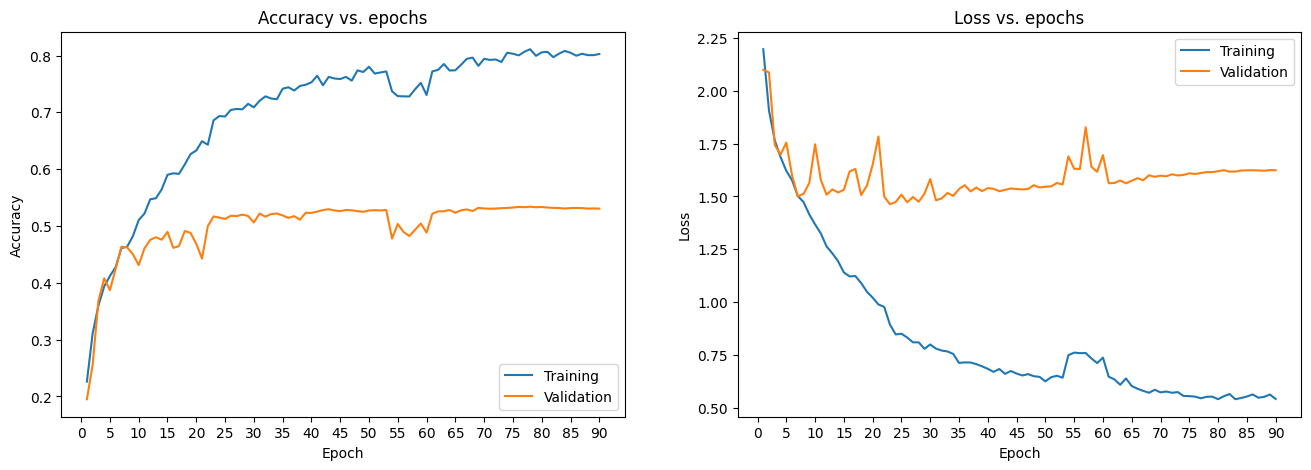

2022-08-16 08:58:06,109: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 08:58:10,230: INFO: test loss:1.6151
2022-08-16 08:58:10,231: INFO: test accuracy:0.5340
2022-08-16 08:58:10,233: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 08:58:10,234: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 08:58:10,235: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 08:58:10,236: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 08:58:10,237: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 08:58:10,575: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator


313/313 [==============================] - 0s 1ms/step


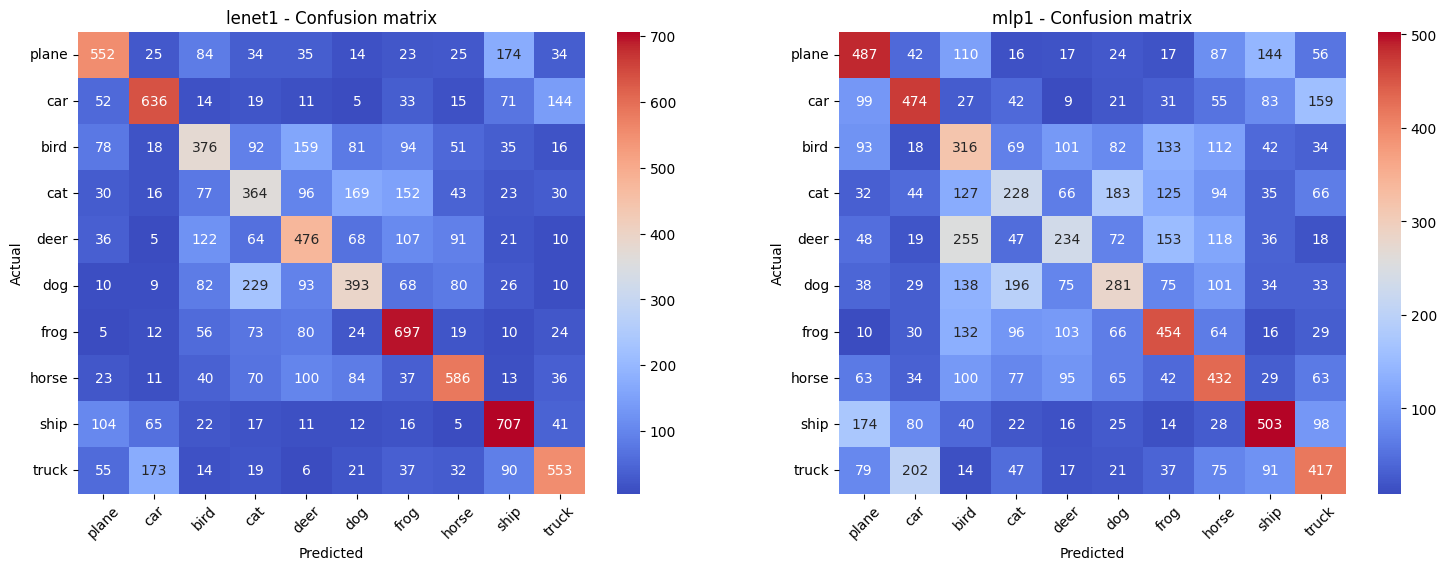

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1     lenet1  cifar10_0816_cnt_500.ipynb          83170       175.9   
2       mlp1  cifar10_0816_cnt_500.ipynb         394634       103.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:58      0.2076     1.6151          0.9548         0.5340   
2  2022-08-16 08:55      1.3138     1.7759          0.5434         0.3826   

   train_auc  test_auc  
1     0.9985    0.8930  
2     0.9025    0.8128

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-16 08:58:14,214: INFO: model_params.custom1.dropout=0.2
2022-08-16 08:58:14,324: INFO: learning_rate=0.001
2022-08-16 08:58:14,325: INFO: model_params.custom1.clip_value=None
2022-08-16 08:58:14,331: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

2022-08-16 08:58:14,361: INFO: model_params.custom1.epochs=90
2022-08-16 08:58:14,362: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1, monitor=val_accuracy)
2022-08-16 08:58:14,362: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:58:14,363: INFO: use LearningRateScheduler()
2022-08-16 08:58:14,364: INFO: steps_per_epoch=156
2022-08-16 08:58:14,364: INFO: start training
2022-08-16 08:58:14,365: INFO: use_class_weight=False


Epoch 1/90
147/156 [===========================>..] - ETA: 0s - loss: 2.2253 - accuracy: 0.2200

2022-08-16 08:58:18,709: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:19,404: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 5s 26ms/step - loss: 2.2068 - accuracy: 0.2248 - val_loss: 3.4238 - val_accuracy: 0.1002 - lr: 0.0010
Epoch 2/90
149/156 [===========================>..] - ETA: 0s - loss: 1.8384 - accuracy: 0.3184

2022-08-16 08:58:22,643: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:23,348: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 25ms/step - loss: 1.8358 - accuracy: 0.3185 - val_loss: 2.9144 - val_accuracy: 0.1813 - lr: 0.0010
Epoch 3/90
150/156 [===========================>..] - ETA: 0s - loss: 1.6727 - accuracy: 0.3921

2022-08-16 08:58:26,957: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:27,647: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 28ms/step - loss: 1.6745 - accuracy: 0.3926 - val_loss: 2.5369 - val_accuracy: 0.2139 - lr: 0.0010
Epoch 4/90
147/156 [===========================>..] - ETA: 0s - loss: 1.5949 - accuracy: 0.4154

2022-08-16 08:58:30,732: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:31,479: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 25ms/step - loss: 1.5912 - accuracy: 0.4147 - val_loss: 1.6784 - val_accuracy: 0.4157 - lr: 0.0010
Epoch 5/90
156/156 [==============================] - 2s 10ms/step - loss: 1.5160 - accuracy: 0.4461 - val_loss: 1.9877 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 6/90
156/156 [==============================] - ETA: 0s - loss: 1.4496 - accuracy: 0.4718

2022-08-16 08:58:36,110: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:37,080: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 26ms/step - loss: 1.4496 - accuracy: 0.4718 - val_loss: 1.5589 - val_accuracy: 0.4471 - lr: 0.0010
Epoch 7/90
154/156 [============================>.] - ETA: 0s - loss: 1.3816 - accuracy: 0.5006

2022-08-16 08:58:40,373: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:41,058: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 26ms/step - loss: 1.3824 - accuracy: 0.5000 - val_loss: 1.4384 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 8/90
156/156 [==============================] - 2s 12ms/step - loss: 1.3082 - accuracy: 0.5286 - val_loss: 1.6250 - val_accuracy: 0.4437 - lr: 0.0010
Epoch 9/90
152/156 [============================>.] - ETA: 0s - loss: 1.2861 - accuracy: 0.5405

2022-08-16 08:58:46,144: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:46,859: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 25ms/step - loss: 1.2853 - accuracy: 0.5409 - val_loss: 1.4074 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 10/90
156/156 [==============================] - 2s 10ms/step - loss: 1.2461 - accuracy: 0.5391 - val_loss: 1.6870 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 11/90
149/156 [===========================>..] - ETA: 0s - loss: 1.1944 - accuracy: 0.5612

2022-08-16 08:58:51,617: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:58:52,636: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 1.1976 - accuracy: 0.5611 - val_loss: 1.3193 - val_accuracy: 0.5289 - lr: 0.0010
Epoch 12/90
156/156 [==============================] - 2s 10ms/step - loss: 1.1444 - accuracy: 0.5793 - val_loss: 1.5104 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 13/90
156/156 [==============================] - 2s 10ms/step - loss: 1.1162 - accuracy: 0.5885 - val_loss: 1.5516 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 14/90
156/156 [==============================] - 2s 12ms/step - loss: 1.0864 - accuracy: 0.6054 - val_loss: 1.6964 - val_accuracy: 0.4055 - lr: 0.0010
Epoch 15/90
156/156 [==============================] - 2s 12ms/step - loss: 1.0438 - accuracy: 0.6216 - val_loss: 1.5584 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 16/90
156/156 [==============================] - 2s 11ms/step - loss: 1.0058 - accuracy: 0.6402 - val_loss: 1.4299 - val_accuracy: 0.5138 - lr: 0.0010
Epoch 17/90
156/156 [==============================] - 2s 12ms/step - 

2022-08-16 08:59:08,203: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:59:08,916: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.9429 - accuracy: 0.6613 - val_loss: 1.2970 - val_accuracy: 0.5513 - lr: 0.0010
Epoch 20/90
156/156 [==============================] - 2s 11ms/step - loss: 0.9139 - accuracy: 0.6739 - val_loss: 1.4492 - val_accuracy: 0.5289 - lr: 0.0010
Epoch 21/90
156/156 [==============================] - 2s 11ms/step - loss: 0.8858 - accuracy: 0.6827 - val_loss: 1.6769 - val_accuracy: 0.4976 - lr: 0.0010
Epoch 22/90
154/156 [============================>.] - ETA: 0s - loss: 0.8584 - accuracy: 0.6976

2022-08-16 08:59:15,928: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:59:16,652: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 0.8604 - accuracy: 0.6971 - val_loss: 1.3180 - val_accuracy: 0.5631 - lr: 0.0010
Epoch 23/90
156/156 [==============================] - 2s 12ms/step - loss: 0.8345 - accuracy: 0.7003 - val_loss: 1.7025 - val_accuracy: 0.4834 - lr: 0.0010
Epoch 24/90
156/156 [==============================] - 2s 11ms/step - loss: 0.8401 - accuracy: 0.6957 - val_loss: 1.5608 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 25/90
156/156 [==============================] - 2s 12ms/step - loss: 0.7961 - accuracy: 0.7149 - val_loss: 2.1498 - val_accuracy: 0.4555 - lr: 0.0010
Epoch 26/90
156/156 [==============================] - 2s 12ms/step - loss: 0.7757 - accuracy: 0.7198 - val_loss: 1.4484 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 27/90
156/156 [==============================] - 2s 11ms/step - loss: 0.7697 - accuracy: 0.7198 - val_loss: 1.4611 - val_accuracy: 0.5298 - lr: 0.0010
Epoch 28/90
155/156 [============================>.] - ETA: 0s - loss:

2022-08-16 08:59:29,411: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:59:30,122: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 28ms/step - loss: 0.7400 - accuracy: 0.7294 - val_loss: 1.3168 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 29/90
156/156 [==============================] - 2s 12ms/step - loss: 0.7311 - accuracy: 0.7360 - val_loss: 1.3604 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 30/90
156/156 [==============================] - 2s 11ms/step - loss: 0.6930 - accuracy: 0.7514 - val_loss: 1.4188 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 31/90
156/156 [==============================] - 2s 11ms/step - loss: 0.6722 - accuracy: 0.7578 - val_loss: 1.3937 - val_accuracy: 0.5555 - lr: 0.0010
Epoch 32/90
155/156 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.7571

2022-08-16 08:59:38,784: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:59:39,493: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 0.6844 - accuracy: 0.7568 - val_loss: 1.2887 - val_accuracy: 0.5916 - lr: 0.0010
Epoch 33/90
156/156 [==============================] - 2s 12ms/step - loss: 0.6597 - accuracy: 0.7546 - val_loss: 2.2777 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 34/90
156/156 [==============================] - 2s 12ms/step - loss: 0.6707 - accuracy: 0.7470 - val_loss: 1.5005 - val_accuracy: 0.5558 - lr: 0.0010
Epoch 35/90
156/156 [==============================] - 2s 12ms/step - loss: 0.6297 - accuracy: 0.7688 - val_loss: 1.7708 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 36/90
156/156 [==============================] - 2s 12ms/step - loss: 0.6307 - accuracy: 0.7650 - val_loss: 1.9411 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 37/90
152/156 [============================>.] - ETA: 0s - loss: 0.6127 - accuracy: 0.7829

2022-08-16 08:59:50,477: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 08:59:51,167: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 0.6130 - accuracy: 0.7833 - val_loss: 1.3425 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 38/90
156/156 [==============================] - 2s 12ms/step - loss: 0.5995 - accuracy: 0.7865 - val_loss: 1.4427 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 39/90
156/156 [==============================] - 2s 12ms/step - loss: 0.5689 - accuracy: 0.7951 - val_loss: 1.4229 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 40/90
156/156 [==============================] - 2s 12ms/step - loss: 0.5763 - accuracy: 0.7943 - val_loss: 2.0865 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 41/90
156/156 [==============================] - 2s 12ms/step - loss: 0.5690 - accuracy: 0.7929 - val_loss: 1.7450 - val_accuracy: 0.5322 - lr: 0.0010
Epoch 42/90
156/156 [==============================] - 2s 12ms/step - loss: 0.5705 - accuracy: 0.7987 - val_loss: 1.5621 - val_accuracy: 0.5562 - lr: 0.0010
Epoch 43/90
156/156 [==============================] - 2s 12ms/step - 

2022-08-16 09:00:17,126: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:00:17,820: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 28ms/step - loss: 0.4297 - accuracy: 0.8484 - val_loss: 1.4263 - val_accuracy: 0.6007 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/90
156/156 [==============================] - 2s 12ms/step - loss: 0.4056 - accuracy: 0.8518 - val_loss: 1.4681 - val_accuracy: 0.5999 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/90
153/156 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8607

2022-08-16 09:00:23,009: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:00:23,793: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.3910 - accuracy: 0.8606 - val_loss: 1.3794 - val_accuracy: 0.6108 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/90
156/156 [==============================] - 2s 11ms/step - loss: 0.3947 - accuracy: 0.8586 - val_loss: 1.4100 - val_accuracy: 0.6070 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/90
156/156 [==============================] - 2s 12ms/step - loss: 0.3992 - accuracy: 0.8542 - val_loss: 1.4948 - val_accuracy: 0.5913 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/90
156/156 [==============================] - 2s 12ms/step - loss: 0.4008 - accuracy: 0.8628 - val_loss: 1.4829 - val_accuracy: 0.5931 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/90
156/156 [==============================] - 2s 12ms/step - loss: 0.3759 - accuracy: 0.8652 - val_

2022-08-16 09:00:41,833: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:00:42,827: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 29ms/step - loss: 0.3449 - accuracy: 0.8758 - val_loss: 1.4254 - val_accuracy: 0.6180 - lr: 1.0000e-04
Epoch 62/90
151/156 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8760

2022-08-16 09:00:46,278: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:00:46,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets



Epoch 62: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
156/156 [==============================] - 4s 27ms/step - loss: 0.3435 - accuracy: 0.8748 - val_loss: 1.4424 - val_accuracy: 0.6182 - lr: 3.1623e-05
Epoch 00063: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 63/90
155/156 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy: 0.8810

2022-08-16 09:00:50,443: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:00:51,192: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 0.3309 - accuracy: 0.8812 - val_loss: 1.4150 - val_accuracy: 0.6225 - lr: 3.1623e-05
Epoch 00064: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 64/90
156/156 [==============================] - 2s 12ms/step - loss: 0.3296 - accuracy: 0.8828 - val_loss: 1.4161 - val_accuracy: 0.6208 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/90
156/156 [==============================] - 2s 10ms/step - loss: 0.3438 - accuracy: 0.8712 - val_loss: 1.4180 - val_accuracy: 0.6223 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/90
152/156 [============================>.] - ETA: 0s - loss: 0.3337 - accuracy: 0.8797

2022-08-16 09:00:57,779: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:00:59,076: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 29ms/step - loss: 0.3349 - accuracy: 0.8782 - val_loss: 1.3961 - val_accuracy: 0.6233 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/90
154/156 [============================>.] - ETA: 0s - loss: 0.3391 - accuracy: 0.8758

2022-08-16 09:01:02,389: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:01:03,118: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.3400 - accuracy: 0.8754 - val_loss: 1.3999 - val_accuracy: 0.6237 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/90
156/156 [==============================] - 2s 11ms/step - loss: 0.3315 - accuracy: 0.8828 - val_loss: 1.4178 - val_accuracy: 0.6219 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/90
156/156 [==============================] - 2s 11ms/step - loss: 0.3220 - accuracy: 0.8836 - val_loss: 1.4220 - val_accuracy: 0.6223 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
149/156 [===========================>..] - ETA: 0s - loss: 0.3438 - accuracy: 0.8758

2022-08-16 09:01:10,012: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:01:10,713: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 0.3516 - accuracy: 0.8742 - val_loss: 1.4031 - val_accuracy: 0.6238 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
156/156 [==============================] - 2s 11ms/step - loss: 0.3175 - accuracy: 0.8928 - val_loss: 1.4123 - val_accuracy: 0.6227 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
156/156 [==============================] - 2s 10ms/step - loss: 0.3233 - accuracy: 0.8902 - val_loss: 1.4269 - val_accuracy: 0.6216 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
156/156 [==============================] - 2s 13ms/step - loss: 0.3319 - accuracy: 0.8806 - val_loss: 1.4152 - val_accuracy: 0.6237 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
156/156 [==============================] - 2s 12ms/step - loss: 0.3169 - accuracy: 0.8866 - val_

2022-08-16 09:01:23,025: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:01:23,790: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 0.3188 - accuracy: 0.8846 - val_loss: 1.4242 - val_accuracy: 0.6244 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
156/156 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8864
Epoch 77: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
156/156 [==============================] - 4s 26ms/step - loss: 0.3304 - accuracy: 0.8864 - val_loss: 1.4204 - val_accuracy: 0.6243 - lr: 1.0000e-05
Epoch 00078: Still keep learning rate 1e-05 instead of 0.0001
Epoch 78/90
156/156 [==============================] - 4s 25ms/step - loss: 0.3161 - accuracy: 0.8904 - val_loss: 1.4164 - val_accuracy: 0.6241 - lr: 1.0000e-05
Epoch 00079: Still keep learning rate 1e-05 instead of 0.0001
Epoch 79/90
151/156 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8911

2022-08-16 09:01:35,094: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


2022-08-16 09:01:35,802: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.3140 - accuracy: 0.8900 - val_loss: 1.4183 - val_accuracy: 0.6246 - lr: 1.0000e-05
Epoch 00080: Still keep learning rate 1e-05 instead of 0.0001
Epoch 80/90
156/156 [==============================] - 2s 10ms/step - loss: 0.3102 - accuracy: 0.8870 - val_loss: 1.4202 - val_accuracy: 0.6240 - lr: 1.0000e-05
Epoch 00081: Still keep learning rate 1e-05 instead of 0.0001
Epoch 81/90
156/156 [==============================] - 2s 10ms/step - loss: 0.3408 - accuracy: 0.8800 - val_loss: 1.4236 - val_accuracy: 0.6238 - lr: 1.0000e-05
Epoch 00082: Still keep learning rate 1e-05 instead of 0.0001
Epoch 82/90
156/156 [==============================] - 2s 10ms/step - loss: 0.3064 - accuracy: 0.8892 - val_loss: 1.4260 - val_accuracy: 0.6216 - lr: 1.0000e-05
Epoch 00083: Still keep learning rate 1e-05 instead of 0.0001
Epoch 83/90
156/156 [==============================] - 2s 10ms/step - loss: 0.3156 - accuracy: 0.8828 - val_loss: 1.4173

2022-08-16 09:01:53,249: INFO: finish training [elapsed time: 218.88 seconds]


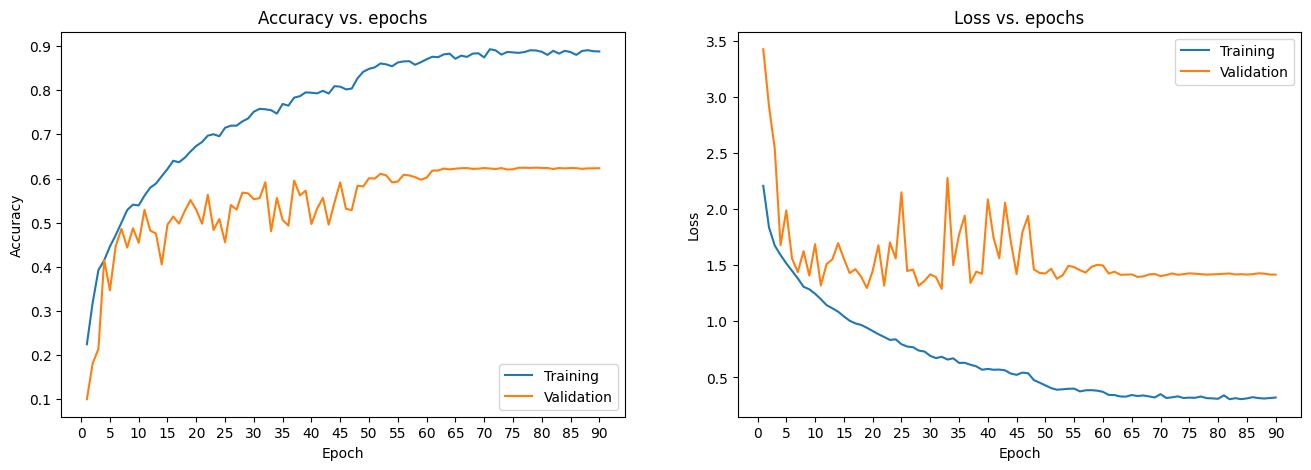

2022-08-16 09:01:53,691: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 09:01:58,198: INFO: test loss:1.4183
2022-08-16 09:01:58,199: INFO: test accuracy:0.6246
2022-08-16 09:01:58,201: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:01:58,202: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:01:58,203: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:01:58,204: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:01:58,205: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:01:59,398: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator


313/313 [==============================] - 1s 2ms/step


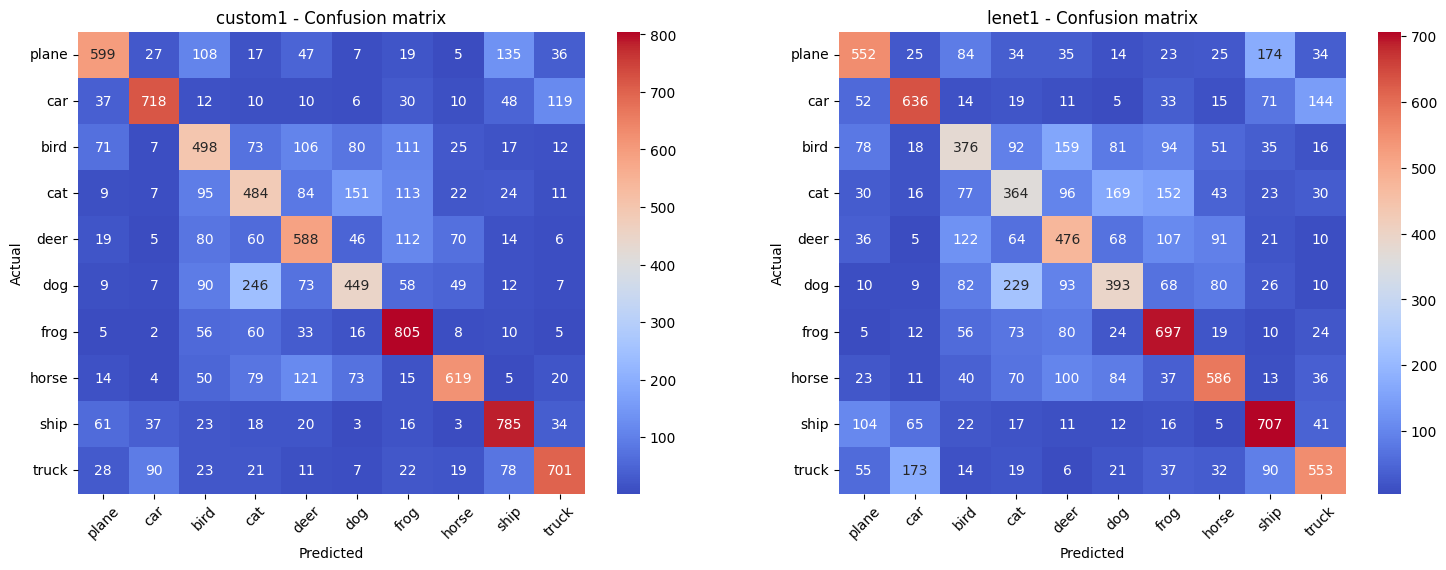

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1    custom1  cifar10_0816_cnt_500.ipynb          73738       218.9   
2     lenet1  cifar10_0816_cnt_500.ipynb          83170       175.9   
3       mlp1  cifar10_0816_cnt_500.ipynb         394634       103.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:01      0.0772     1.4183          0.9882         0.6246   
2  2022-08-16 08:58      0.2076     1.6151          0.9548         0.5340   
3  2022-08-16 08:55      1.3138     1.7759          0.5434         0.3826   

   train_auc  test_auc  
1     0.9998    0.9292  
2     0.9985    0.8930  
3     0.9025    0.8128

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [26]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[ 46  82 132]
 [ 38  74 123]
 [ 38  74 124]
 [ 36  72 123]
 [ 34  69 120]], shape=(5, 3), dtype=uint8)
tf.Tensor(
[[0.18039216 0.32156864 0.5176471 ]
 [0.14901961 0.2901961  0.48235297]
 [0.14901961 0.2901961  0.48627454]
 [0.14117648 0.28235295 0.48235297]
 [0.13333334 0.27058825 0.47058827]], shape=(5, 3), dtype=float32)


In [27]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-16 09:02:03,303: INFO: model_params.vgg8.dropout=0.1
2022-08-16 09:02:03,503: INFO: learning_rate=0.001
2022-08-16 09:02:03,504: INFO: model_params.vgg8.clip_value=None
2022-08-16 09:02:03,511: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                              

2022-08-16 09:02:03,652: INFO: model_params.vgg8.epochs=90
2022-08-16 09:02:03,653: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8, monitor=val_accuracy)
2022-08-16 09:02:03,654: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:02:03,654: INFO: use LearningRateScheduler()
2022-08-16 09:02:03,655: INFO: steps_per_epoch=156
2022-08-16 09:02:03,656: INFO: start training
2022-08-16 09:02:03,656: INFO: use_class_weight=False


Epoch 1/90
152/156 [============================>.] - ETA: 0s - loss: 2.1220 - accuracy: 0.2455

2022-08-16 09:02:10,717: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:02:12,141: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 9s 47ms/step - loss: 2.1121 - accuracy: 0.2480 - val_loss: 3.2049 - val_accuracy: 0.1006 - lr: 0.0010
Epoch 2/90
152/156 [============================>.] - ETA: 0s - loss: 1.7176 - accuracy: 0.3744

2022-08-16 09:02:17,773: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:02:18,923: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 44ms/step - loss: 1.7129 - accuracy: 0.3752 - val_loss: 3.1761 - val_accuracy: 0.1242 - lr: 0.0010
Epoch 3/90
153/156 [============================>.] - ETA: 0s - loss: 1.4993 - accuracy: 0.4512

2022-08-16 09:02:24,671: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:02:26,081: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 1.4960 - accuracy: 0.4513 - val_loss: 2.0713 - val_accuracy: 0.3288 - lr: 0.0010
Epoch 4/90
156/156 [==============================] - ETA: 0s - loss: 1.3573 - accuracy: 0.4954

2022-08-16 09:02:31,210: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:02:32,412: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 6s 41ms/step - loss: 1.3573 - accuracy: 0.4954 - val_loss: 1.7860 - val_accuracy: 0.4466 - lr: 0.0010
Epoch 5/90
156/156 [==============================] - 3s 20ms/step - loss: 1.2379 - accuracy: 0.5443 - val_loss: 2.5457 - val_accuracy: 0.3521 - lr: 0.0010
Epoch 6/90
154/156 [============================>.] - ETA: 0s - loss: 1.1012 - accuracy: 0.5944

2022-08-16 09:02:41,478: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:02:42,709: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 47ms/step - loss: 1.0993 - accuracy: 0.5958 - val_loss: 1.2605 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 7/90
156/156 [==============================] - 3s 21ms/step - loss: 1.0142 - accuracy: 0.6292 - val_loss: 2.0336 - val_accuracy: 0.4498 - lr: 0.0010
Epoch 8/90
154/156 [============================>.] - ETA: 0s - loss: 0.9344 - accuracy: 0.6652

2022-08-16 09:02:51,740: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:02:52,810: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 44ms/step - loss: 0.9330 - accuracy: 0.6651 - val_loss: 1.3043 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 9/90
156/156 [==============================] - 3s 20ms/step - loss: 0.8374 - accuracy: 0.6959 - val_loss: 1.3423 - val_accuracy: 0.5501 - lr: 0.0010
Epoch 10/90
156/156 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.7244

2022-08-16 09:03:02,132: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:03:03,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 48ms/step - loss: 0.7669 - accuracy: 0.7244 - val_loss: 1.1925 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 11/90
156/156 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.7360

2022-08-16 09:03:09,144: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:03:10,303: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 45ms/step - loss: 0.7036 - accuracy: 0.7360 - val_loss: 1.2451 - val_accuracy: 0.5987 - lr: 0.0010
Epoch 12/90
153/156 [============================>.] - ETA: 0s - loss: 0.6104 - accuracy: 0.7796

2022-08-16 09:03:16,341: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:03:17,495: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 0.6108 - accuracy: 0.7792 - val_loss: 1.3076 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 13/90
156/156 [==============================] - 3s 20ms/step - loss: 0.5597 - accuracy: 0.7989 - val_loss: 1.3243 - val_accuracy: 0.5754 - lr: 0.0010
Epoch 14/90
156/156 [==============================] - 3s 19ms/step - loss: 0.4863 - accuracy: 0.8251 - val_loss: 1.4335 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 15/90
156/156 [==============================] - 3s 21ms/step - loss: 0.4713 - accuracy: 0.8311 - val_loss: 1.5174 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 16/90
156/156 [==============================] - 3s 21ms/step - loss: 0.4449 - accuracy: 0.8405 - val_loss: 1.4246 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 17/90
156/156 [==============================] - 3s 21ms/step - loss: 0.4059 - accuracy: 0.8592 - val_loss: 1.7837 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 18/90
156/156 [==============================] - 3s 21ms/step - 

2022-08-16 09:03:42,456: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:03:43,608: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 0.3359 - accuracy: 0.8854 - val_loss: 1.6042 - val_accuracy: 0.6065 - lr: 0.0010
Epoch 20/90
156/156 [==============================] - 3s 20ms/step - loss: 0.3172 - accuracy: 0.8862 - val_loss: 1.6476 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 21/90
156/156 [==============================] - 3s 20ms/step - loss: 0.2963 - accuracy: 0.8948 - val_loss: 1.5547 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 22/90
156/156 [==============================] - 3s 19ms/step - loss: 0.2863 - accuracy: 0.9022 - val_loss: 1.7274 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 23/90
154/156 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9089

2022-08-16 09:03:58,499: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:03:59,644: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 42ms/step - loss: 0.2621 - accuracy: 0.9095 - val_loss: 1.4678 - val_accuracy: 0.6142 - lr: 0.0010
Epoch 24/90
156/156 [==============================] - 3s 18ms/step - loss: 0.2740 - accuracy: 0.9073 - val_loss: 1.5204 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 25/90
156/156 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9163

2022-08-16 09:04:08,981: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:04:10,455: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
156/156 [==============================] - 8s 51ms/step - loss: 0.2450 - accuracy: 0.9163 - val_loss: 1.7025 - val_accuracy: 0.6256 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
154/156 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9440

2022-08-16 09:04:18,222: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:04:19,376: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 9s 57ms/step - loss: 0.1718 - accuracy: 0.9445 - val_loss: 1.5204 - val_accuracy: 0.6671 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
155/156 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9532

2022-08-16 09:04:28,534: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:04:29,698: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 10s 66ms/step - loss: 0.1571 - accuracy: 0.9531 - val_loss: 1.4793 - val_accuracy: 0.6769 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
155/156 [============================>.] - ETA: 0s - loss: 0.1290 - accuracy: 0.9595

2022-08-16 09:04:35,663: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:04:36,800: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 45ms/step - loss: 0.1297 - accuracy: 0.9593 - val_loss: 1.4419 - val_accuracy: 0.6858 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
156/156 [==============================] - 3s 18ms/step - loss: 0.1316 - accuracy: 0.9583 - val_loss: 1.4889 - val_accuracy: 0.6762 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
155/156 [============================>.] - ETA: 0s - loss: 0.1241 - accuracy: 0.9631

2022-08-16 09:04:46,688: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:04:47,825: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 8s 53ms/step - loss: 0.1239 - accuracy: 0.9633 - val_loss: 1.4452 - val_accuracy: 0.6882 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
156/156 [==============================] - 4s 24ms/step - loss: 0.1318 - accuracy: 0.9589 - val_loss: 1.5013 - val_accuracy: 0.6772 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
156/156 [==============================] - 4s 24ms/step - loss: 0.1080 - accuracy: 0.9681 - val_loss: 1.5452 - val_accuracy: 0.6810 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
156/156 [==============================] - 5s 30ms/step - loss: 0.1117 - accuracy: 0.9673 - val_loss: 1.5001 - val_accuracy: 0.6867 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
156/156 [==============================] - 3s 20ms/step - loss: 0.1062 - accuracy: 0.9669 - val_

2022-08-16 09:05:39,504: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:05:40,645: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 42ms/step - loss: 0.0898 - accuracy: 0.9758 - val_loss: 1.6776 - val_accuracy: 0.6915 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
155/156 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9742

2022-08-16 09:05:46,781: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:05:47,948: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 7s 47ms/step - loss: 0.0876 - accuracy: 0.9740 - val_loss: 1.6296 - val_accuracy: 0.6954 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
156/156 [==============================] - 5s 29ms/step - loss: 0.0748 - accuracy: 0.9778 - val_loss: 1.6658 - val_accuracy: 0.6910 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
155/156 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9760

2022-08-16 09:06:01,036: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:06:02,160: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 10s 62ms/step - loss: 0.0793 - accuracy: 0.9760 - val_loss: 1.6501 - val_accuracy: 0.6956 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
156/156 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9746

2022-08-16 09:06:09,001: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:06:10,125: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 8s 51ms/step - loss: 0.0945 - accuracy: 0.9746 - val_loss: 1.6594 - val_accuracy: 0.6963 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
156/156 [==============================] - 4s 28ms/step - loss: 0.0825 - accuracy: 0.9778 - val_loss: 1.7366 - val_accuracy: 0.6852 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
156/156 [==============================] - 6s 39ms/step - loss: 0.0817 - accuracy: 0.9782 - val_loss: 1.6779 - val_accuracy: 0.6915 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
156/156 [==============================] - 4s 23ms/step - loss: 0.0706 - accuracy: 0.9816 - val_loss: 1.7058 - val_accuracy: 0.6925 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
156/156 [==============================] - 4s 26ms/step - loss: 0.0775 - accuracy: 0.9788 - val_loss: 1.7887

2022-08-16 09:06:48,411: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:06:49,584: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 8s 52ms/step - loss: 0.0721 - accuracy: 0.9820 - val_loss: 1.7667 - val_accuracy: 0.6968 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/90
155/156 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9808
Epoch 55: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
156/156 [==============================] - 5s 33ms/step - loss: 0.0678 - accuracy: 0.9808 - val_loss: 1.7885 - val_accuracy: 0.6900 - lr: 3.1623e-05
Epoch 00056: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
Epoch 56/90
156/156 [==============================] - 4s 27ms/step - loss: 0.7297 - accuracy: 0.7630 - val_loss: 1.9612 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 57/90
156/156 [==============================] - 5s 32ms/step - loss: 0.4299 - accuracy: 0.8526 - val_loss: 1.9601 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 58/90
156/156 [==============================] - 6s 37ms/step -

2022-08-16 09:08:12,659: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:08:13,791: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 9s 59ms/step - loss: 0.0813 - accuracy: 0.9736 - val_loss: 1.5624 - val_accuracy: 0.6980 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
156/156 [==============================] - 6s 39ms/step - loss: 0.0713 - accuracy: 0.9768 - val_loss: 1.5657 - val_accuracy: 0.6977 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
156/156 [==============================] - 4s 28ms/step - loss: 0.0705 - accuracy: 0.9770 - val_loss: 1.5858 - val_accuracy: 0.6961 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
156/156 [==============================] - 5s 31ms/step - loss: 0.0724 - accuracy: 0.9788 - val_loss: 1.5980 - val_accuracy: 0.6968 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/90
156/156 [==============================] - 5s 35ms/step - loss: 0.0773 - accuracy: 0.9764 - val_

2022-08-16 09:08:47,874: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:08:49,018: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 9s 61ms/step - loss: 0.0644 - accuracy: 0.9790 - val_loss: 1.6039 - val_accuracy: 0.6992 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
156/156 [==============================] - 11s 69ms/step - loss: 0.0807 - accuracy: 0.9742 - val_loss: 1.6161 - val_accuracy: 0.6947 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
156/156 [==============================] - 10s 66ms/step - loss: 0.0757 - accuracy: 0.9742 - val_loss: 1.6249 - val_accuracy: 0.6948 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/90
156/156 [==============================] - 6s 41ms/step - loss: 0.0731 - accuracy: 0.9774 - val_loss: 1.6176 - val_accuracy: 0.6970 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/90
156/156 [==============================] - 5s 32ms/step - loss: 0.0611 - accuracy: 0.9818 - va

2022-08-16 09:09:34,785: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


2022-08-16 09:09:35,914: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8/assets


156/156 [==============================] - 9s 59ms/step - loss: 0.0640 - accuracy: 0.9808 - val_loss: 1.6269 - val_accuracy: 0.7000 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/90
156/156 [==============================] - 10s 65ms/step - loss: 0.0687 - accuracy: 0.9798 - val_loss: 1.6148 - val_accuracy: 0.6992 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/90
156/156 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9834
Epoch 85: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
156/156 [==============================] - 10s 61ms/step - loss: 0.0593 - accuracy: 0.9834 - val_loss: 1.6569 - val_accuracy: 0.6977 - lr: 1.0000e-05
Epoch 00086: Still keep learning rate 1e-05 instead of 0.0001
Epoch 86/90
156/156 [==============================] - 8s 51ms/step - loss: 0.0678 - accuracy: 0.9786 - val_loss: 1.6515 - val_accuracy: 0.6972 - lr: 1.0000e-05
Epoch 00087:

2022-08-16 09:10:21,330: INFO: finish training [elapsed time: 497.67 seconds]


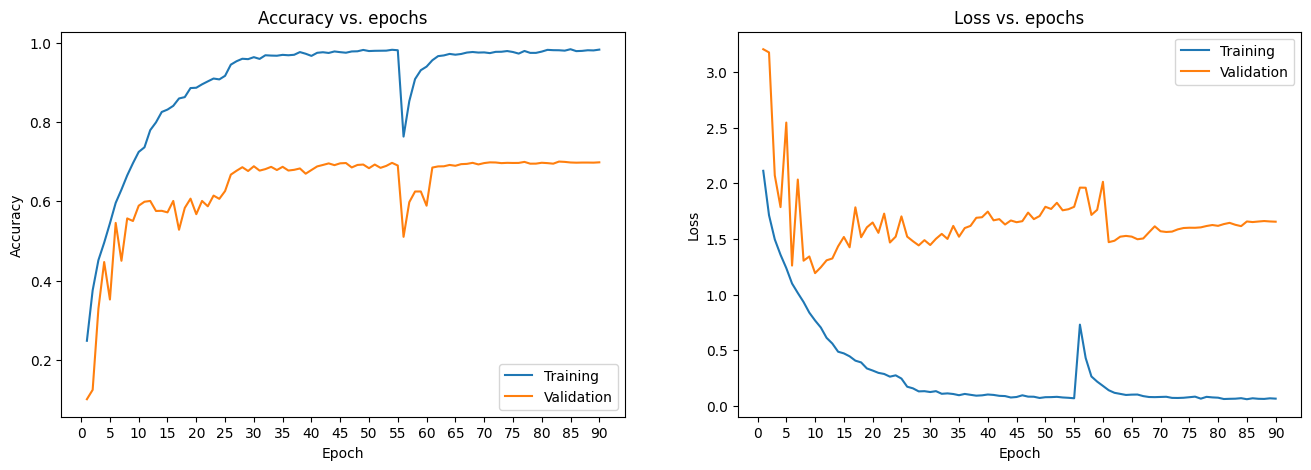

2022-08-16 09:10:21,767: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 5ms/step


2022-08-16 09:10:32,583: INFO: test loss:1.6269
2022-08-16 09:10:32,583: INFO: test accuracy:0.7000
2022-08-16 09:10:32,586: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:10:32,587: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:10:32,588: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:10:32,589: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:10:32,590: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/custom1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:10:33,755: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator


313/313 [==============================] - 1s 4ms/step


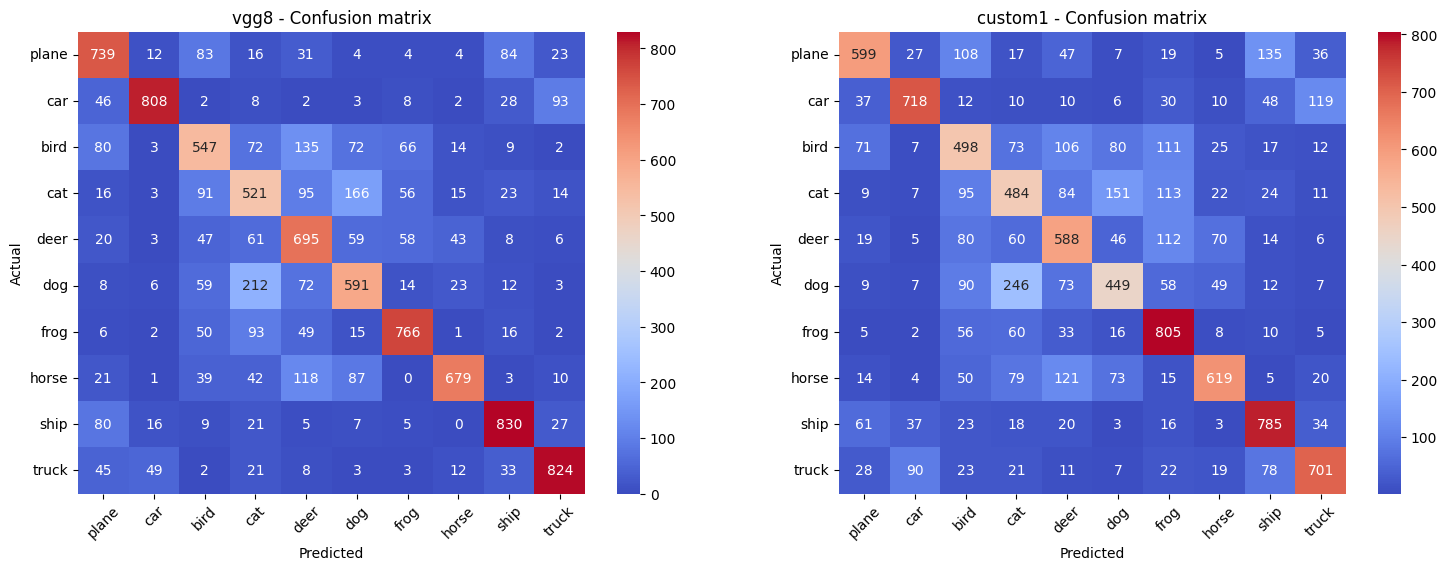

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1       vgg8  cifar10_0816_cnt_500.ipynb        1672906       497.7   
2    custom1  cifar10_0816_cnt_500.ipynb          73738       218.9   
3     lenet1  cifar10_0816_cnt_500.ipynb          83170       175.9   
4       mlp1  cifar10_0816_cnt_500.ipynb         394634       103.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:10      0.0072     1.6269          0.9992         0.7000   
2  2022-08-16 09:01      0.0772     1.4183          0.9882         0.6246   
3  2022-08-16 08:58      0.2076     1.6151          0.9548         0.5340   
4  2022-08-16 08:55      1.3138     1.7759          0.5434         0.3826   

   train_auc  test_auc  
1     1.0000    0.9473  
2     0.9998    0.9292  
3     0.9985    0.8930  
4     0.9025    0.8128

In [28]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-16 09:10:39,714: INFO: learning_rate=0.001
2022-08-16 09:10:39,715: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-16 09:10:39,723: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['rescaling[4][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_nor

 add_8 (Add)                    (None, 8, 8, 64)     0           ['activation_16[0][0]',          
                                                                  'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (

2022-08-16 09:10:39,855: INFO: model_params.resnet_v1_20.epochs=90
2022-08-16 09:10:39,856: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20, monitor=val_accuracy)
2022-08-16 09:10:39,856: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:10:39,857: INFO: use LearningRateScheduler()
2022-08-16 09:10:39,857: INFO: steps_per_epoch=156
2022-08-16 09:10:39,858: INFO: start training
2022-08-16 09:10:39,858: INFO: use_class_weight=False


Epoch 1/90
154/156 [============================>.] - ETA: 0s - loss: 2.0494 - accuracy: 0.3192

2022-08-16 09:11:02,760: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:11:05,812: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 26s 140ms/step - loss: 2.0464 - accuracy: 0.3197 - val_loss: 2.5459 - val_accuracy: 0.2491 - lr: 0.0010
Epoch 2/90
155/156 [============================>.] - ETA: 0s - loss: 1.6373 - accuracy: 0.4609

2022-08-16 09:11:18,323: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:11:21,618: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 16s 102ms/step - loss: 1.6361 - accuracy: 0.4615 - val_loss: 2.1545 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 3/90
156/156 [==============================] - ETA: 0s - loss: 1.4200 - accuracy: 0.5487

2022-08-16 09:11:40,073: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:11:43,686: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 22s 142ms/step - loss: 1.4200 - accuracy: 0.5487 - val_loss: 2.1472 - val_accuracy: 0.3943 - lr: 0.0010
Epoch 4/90
156/156 [==============================] - 6s 39ms/step - loss: 1.2242 - accuracy: 0.6214 - val_loss: 3.2519 - val_accuracy: 0.3452 - lr: 0.0010
Epoch 5/90
156/156 [==============================] - 6s 36ms/step - loss: 1.0528 - accuracy: 0.6903 - val_loss: 3.4813 - val_accuracy: 0.3149 - lr: 0.0010
Epoch 6/90
156/156 [==============================] - 12s 74ms/step - loss: 0.9474 - accuracy: 0.7306 - val_loss: 2.9844 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 7/90
156/156 [==============================] - 9s 56ms/step - loss: 0.8047 - accuracy: 0.7833 - val_loss: 4.7660 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 8/90
156/156 [==============================] - 5s 31ms/step - loss: 0.7204 - accuracy: 0.8119 - val_loss: 4.8584 - val_accuracy: 0.3180 - lr: 0.0010
Epoch 9/90
156/156 [==============================] - 5s 31ms/step - los

2022-08-16 09:13:21,495: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:13:24,619: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 16s 105ms/step - loss: 0.2939 - accuracy: 0.9698 - val_loss: 3.8851 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 17/90
155/156 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.9659

2022-08-16 09:13:42,320: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:13:45,368: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 21s 133ms/step - loss: 0.2986 - accuracy: 0.9661 - val_loss: 3.4453 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 18/90
154/156 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.9700
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
156/156 [==============================] - 5s 34ms/step - loss: 0.2966 - accuracy: 0.9696 - val_loss: 5.1273 - val_accuracy: 0.3051 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/90
153/156 [============================>.] - ETA: 0s - loss: 0.2514 - accuracy: 0.9835

2022-08-16 09:14:03,316: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:14:06,607: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 16s 102ms/step - loss: 0.2506 - accuracy: 0.9838 - val_loss: 2.9091 - val_accuracy: 0.4713 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/90
155/156 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9996

2022-08-16 09:14:25,659: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:14:28,739: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 22s 143ms/step - loss: 0.2030 - accuracy: 0.9996 - val_loss: 2.4643 - val_accuracy: 0.5071 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/90
156/156 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 1.0000

2022-08-16 09:14:43,140: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:14:46,238: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 17s 113ms/step - loss: 0.1965 - accuracy: 1.0000 - val_loss: 2.4688 - val_accuracy: 0.5073 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/90
155/156 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 1.0000

2022-08-16 09:15:03,865: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:15:06,879: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 21s 132ms/step - loss: 0.1943 - accuracy: 1.0000 - val_loss: 2.4866 - val_accuracy: 0.5079 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/90
156/156 [==============================] - 5s 30ms/step - loss: 0.1927 - accuracy: 1.0000 - val_loss: 2.5018 - val_accuracy: 0.5077 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
155/156 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 1.0000

2022-08-16 09:15:25,552: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:15:28,625: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 17s 110ms/step - loss: 0.1911 - accuracy: 1.0000 - val_loss: 2.5146 - val_accuracy: 0.5084 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
156/156 [==============================] - 11s 73ms/step - loss: 0.1895 - accuracy: 1.0000 - val_loss: 2.5260 - val_accuracy: 0.5083 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
154/156 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 1.0000

2022-08-16 09:15:52,993: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:15:56,109: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 16s 104ms/step - loss: 0.1880 - accuracy: 1.0000 - val_loss: 2.5362 - val_accuracy: 0.5085 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
156/156 [==============================] - 5s 34ms/step - loss: 0.1863 - accuracy: 1.0000 - val_loss: 2.5455 - val_accuracy: 0.5082 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
156/156 [==============================] - 6s 37ms/step - loss: 0.1847 - accuracy: 1.0000 - val_loss: 2.5538 - val_accuracy: 0.5078 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
156/156 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 1.0000

2022-08-16 09:16:28,277: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:16:31,333: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 24s 155ms/step - loss: 0.1829 - accuracy: 1.0000 - val_loss: 2.5617 - val_accuracy: 0.5089 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
156/156 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 1.0000

2022-08-16 09:16:45,296: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:16:48,357: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 17s 109ms/step - loss: 0.1811 - accuracy: 1.0000 - val_loss: 2.5687 - val_accuracy: 0.5095 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
156/156 [==============================] - 5s 34ms/step - loss: 0.1792 - accuracy: 1.0000 - val_loss: 2.5752 - val_accuracy: 0.5093 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
156/156 [==============================] - 7s 43ms/step - loss: 0.1772 - accuracy: 1.0000 - val_loss: 2.5811 - val_accuracy: 0.5088 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
156/156 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 1.0000
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
156/156 [==============================] - 17s 109ms/step - loss: 0.1751 - accuracy: 1.0000 - val_loss: 2.5865 - val_accuracy: 0.5086 - lr: 1.0000e-04
Epoch 

2022-08-16 09:21:21,564: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:21:24,634: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 17s 108ms/step - loss: 0.7049 - accuracy: 0.7997 - val_loss: 1.5309 - val_accuracy: 0.5283 - lr: 1.0000e-04
Epoch 62/90
154/156 [============================>.] - ETA: 0s - loss: 0.5435 - accuracy: 0.8669

2022-08-16 09:21:42,901: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:21:45,847: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 21s 136ms/step - loss: 0.5431 - accuracy: 0.8670 - val_loss: 1.5406 - val_accuracy: 0.5315 - lr: 1.0000e-04
Epoch 63/90
154/156 [============================>.] - ETA: 0s - loss: 0.4489 - accuracy: 0.9042

2022-08-16 09:21:58,187: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:22:01,351: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 15s 100ms/step - loss: 0.4484 - accuracy: 0.9040 - val_loss: 1.5956 - val_accuracy: 0.5349 - lr: 1.0000e-04
Epoch 64/90
155/156 [============================>.] - ETA: 0s - loss: 0.3703 - accuracy: 0.9351

2022-08-16 09:22:17,573: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


2022-08-16 09:22:20,542: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20/assets


156/156 [==============================] - 19s 124ms/step - loss: 0.3697 - accuracy: 0.9349 - val_loss: 1.6719 - val_accuracy: 0.5357 - lr: 1.0000e-04
Epoch 65/90
156/156 [==============================] - 4s 28ms/step - loss: 0.3040 - accuracy: 0.9587 - val_loss: 1.7592 - val_accuracy: 0.5356 - lr: 1.0000e-04
Epoch 66/90
156/156 [==============================] - 4s 28ms/step - loss: 0.2512 - accuracy: 0.9760 - val_loss: 1.8550 - val_accuracy: 0.5334 - lr: 1.0000e-04
Epoch 67/90
156/156 [==============================] - 4s 28ms/step - loss: 0.2091 - accuracy: 0.9860 - val_loss: 1.9552 - val_accuracy: 0.5303 - lr: 1.0000e-04
Epoch 68/90
156/156 [==============================] - 4s 28ms/step - loss: 0.1779 - accuracy: 0.9950 - val_loss: 2.0457 - val_accuracy: 0.5301 - lr: 1.0000e-04
Epoch 69/90
156/156 [==============================] - 8s 53ms/step - loss: 0.1564 - accuracy: 0.9976 - val_loss: 2.1225 - val_accuracy: 0.5293 - lr: 1.0000e-04
Epoch 70/90
156/156 [=======================

2022-08-16 09:25:12,177: INFO: finish training [elapsed time: 872.32 seconds]


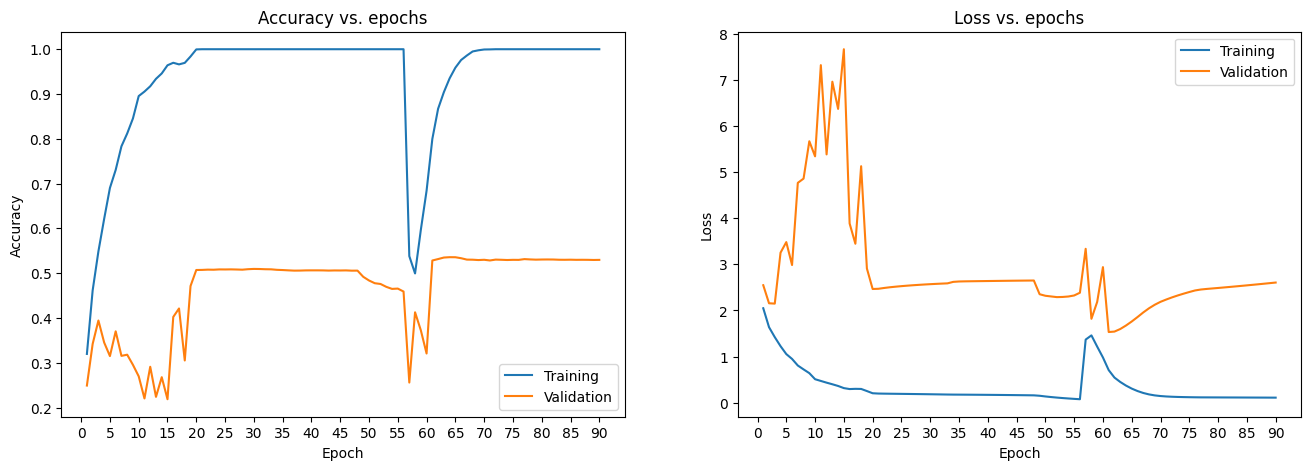

2022-08-16 09:25:12,632: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-16 09:25:26,890: INFO: test loss:1.6719
2022-08-16 09:25:26,891: INFO: test accuracy:0.5357
2022-08-16 09:25:26,895: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:25:26,896: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:25:26,897: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:25:26,898: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:25:26,899: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:25:28,584: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator


313/313 [==============================] - 2s 6ms/step


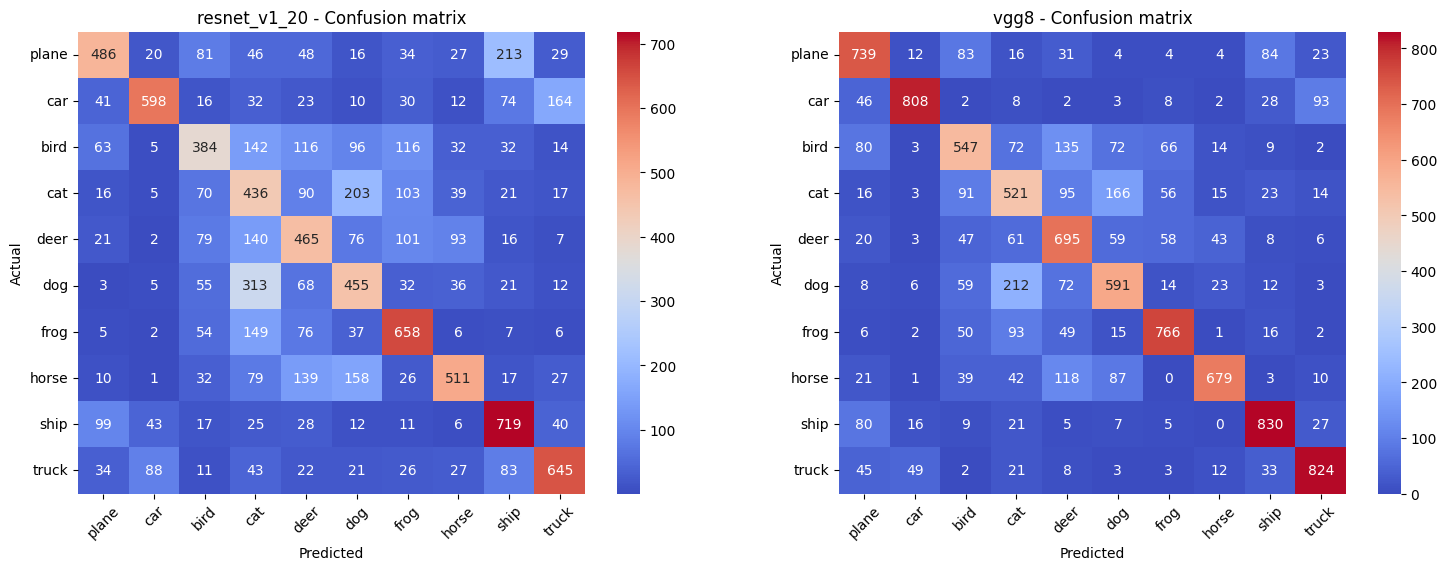

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1          vgg8  cifar10_0816_cnt_500.ipynb        1672906       497.7   
2       custom1  cifar10_0816_cnt_500.ipynb          73738       218.9   
3  resnet_v1_20  cifar10_0816_cnt_500.ipynb         273066       872.3   
4        lenet1  cifar10_0816_cnt_500.ipynb          83170       175.9   
5          mlp1  cifar10_0816_cnt_500.ipynb         394634       103.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:10      0.0072     1.6269          0.9992         0.7000   
2  2022-08-16 09:01      0.0772     1.4183          0.9882         0.6246   
3  2022-08-16 09:25      0.3798     1.6719          0.9262         0.5357   
4  2022-08-16 08:58      0.2076     1.6151          0.9548         0.5340   
5  2022-08-16 08:55      1.3138     1.7759          0.5434         0.3826   

   train_auc  test_auc  
1     1.0000    0.9473  
2     0.9998    0.9292  
3     0.9967    0.8983  
4     0.9985    0.8930  
5     0.9025    0.8128

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [37]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [38]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [39]:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


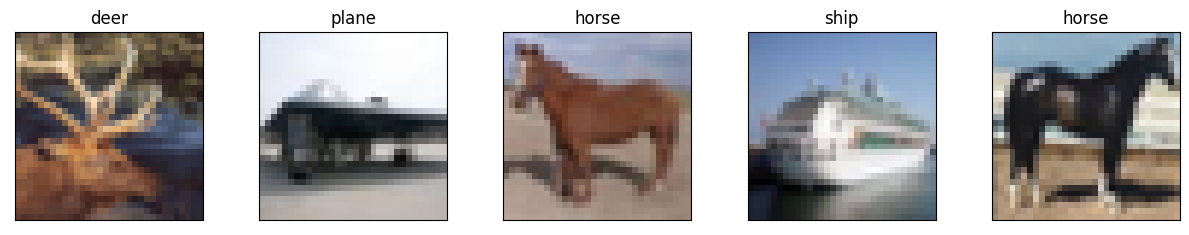

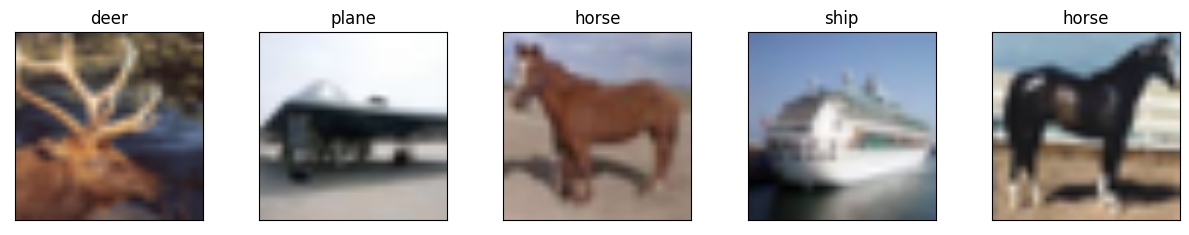

In [40]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [44]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [45]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [46]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-16 09:39:22,496: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-16 09:39:22,496: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-16 09:39:22,504: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer_2 (ResizeLayer  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
           

2022-08-16 09:39:31,230: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 09:39:31,231: INFO: steps_per_epoch=156
2022-08-16 09:39:31,232: INFO: start training
2022-08-16 09:39:31,233: INFO: use_class_weight=False


Epoch 1/10
154/156 [============================>.] - ETA: 0s - loss: 2.3571 - accuracy: 0.2094

2022-08-16 09:39:59,131: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:40:03,590: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 33s 196ms/step - loss: 2.3485 - accuracy: 0.2119 - val_loss: 1.6760 - val_accuracy: 0.4312
Epoch 2/10
154/156 [============================>.] - ETA: 0s - loss: 1.5484 - accuracy: 0.4706

2022-08-16 09:40:29,196: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:40:33,963: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 30s 196ms/step - loss: 1.5448 - accuracy: 0.4720 - val_loss: 1.1884 - val_accuracy: 0.6299
Epoch 3/10
154/156 [============================>.] - ETA: 0s - loss: 1.1731 - accuracy: 0.6092

2022-08-16 09:41:00,083: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:41:04,469: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 31s 197ms/step - loss: 1.1709 - accuracy: 0.6102 - val_loss: 0.9538 - val_accuracy: 0.7020
Epoch 4/10
154/156 [============================>.] - ETA: 0s - loss: 0.9805 - accuracy: 0.6784

2022-08-16 09:41:31,204: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:41:36,146: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 32s 204ms/step - loss: 0.9800 - accuracy: 0.6773 - val_loss: 0.8255 - val_accuracy: 0.7406
Epoch 5/10
154/156 [============================>.] - ETA: 0s - loss: 0.8566 - accuracy: 0.7068

2022-08-16 09:42:05,402: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:42:10,001: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 34s 218ms/step - loss: 0.8560 - accuracy: 0.7069 - val_loss: 0.7480 - val_accuracy: 0.7607
Epoch 6/10
156/156 [==============================] - ETA: 0s - loss: 0.7730 - accuracy: 0.7444

2022-08-16 09:42:37,929: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:42:42,549: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 32s 209ms/step - loss: 0.7730 - accuracy: 0.7444 - val_loss: 0.6957 - val_accuracy: 0.7716
Epoch 7/10
154/156 [============================>.] - ETA: 0s - loss: 0.7075 - accuracy: 0.7620

2022-08-16 09:43:09,427: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:43:13,949: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 31s 202ms/step - loss: 0.7065 - accuracy: 0.7622 - val_loss: 0.6580 - val_accuracy: 0.7826
Epoch 8/10
154/156 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.7731

2022-08-16 09:43:40,966: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:43:45,482: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 31s 203ms/step - loss: 0.6692 - accuracy: 0.7726 - val_loss: 0.6287 - val_accuracy: 0.7901
Epoch 9/10
154/156 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.7916

2022-08-16 09:44:12,586: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:44:17,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 32s 203ms/step - loss: 0.6225 - accuracy: 0.7923 - val_loss: 0.6072 - val_accuracy: 0.7964
Epoch 10/10
154/156 [============================>.] - ETA: 0s - loss: 0.6031 - accuracy: 0.7946

2022-08-16 09:44:43,937: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:44:48,398: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 31s 202ms/step - loss: 0.6022 - accuracy: 0.7943 - val_loss: 0.5889 - val_accuracy: 0.8023


2022-08-16 09:44:49,116: INFO: finish training [elapsed time: 317.88 seconds]


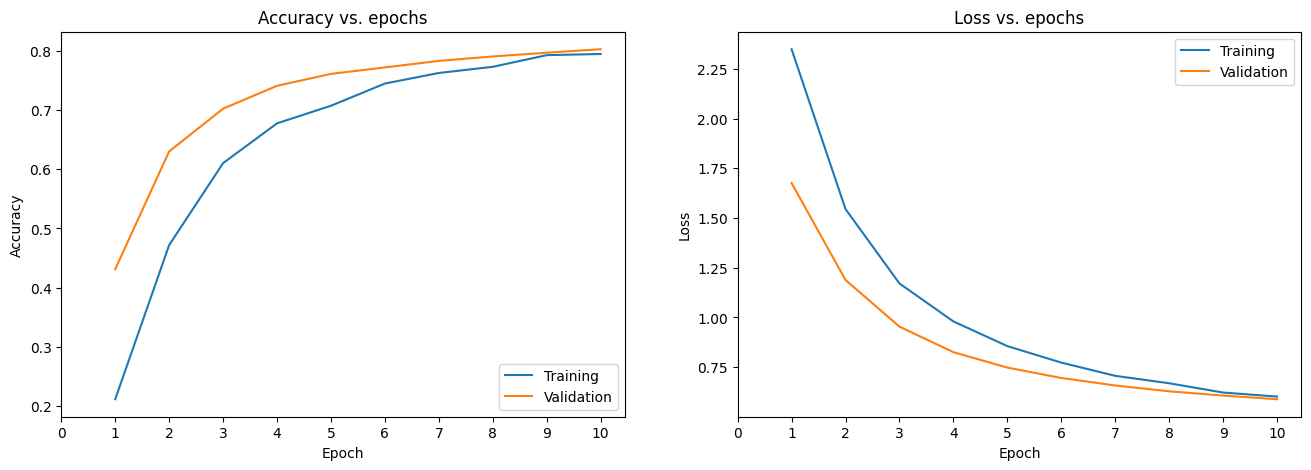

In [47]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [48]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-16 09:44:49,663: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 09:44:49,663: INFO: steps_per_epoch=156
2022-08-16 09:44:49,664: INFO: start training
2022-08-16 09:44:49,665: INFO: use_class_weight=False


Epoch 1/15
155/156 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.8089

2022-08-16 09:45:28,283: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:45:33,022: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 44s 252ms/step - loss: 0.5281 - accuracy: 0.8085 - val_loss: 0.4945 - val_accuracy: 0.8318
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8502

2022-08-16 09:46:10,542: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:46:15,684: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 43s 275ms/step - loss: 0.4178 - accuracy: 0.8502 - val_loss: 0.4576 - val_accuracy: 0.8485
Epoch 3/15
155/156 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8819

2022-08-16 09:46:52,085: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:46:57,224: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 42s 267ms/step - loss: 0.3387 - accuracy: 0.8820 - val_loss: 0.4480 - val_accuracy: 0.8503
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9054

2022-08-16 09:47:34,032: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:47:39,550: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 42s 273ms/step - loss: 0.2783 - accuracy: 0.9054 - val_loss: 0.4353 - val_accuracy: 0.8580
Epoch 5/15
155/156 [============================>.] - ETA: 0s - loss: 0.2288 - accuracy: 0.9210

2022-08-16 09:48:11,333: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:48:16,935: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 37s 241ms/step - loss: 0.2284 - accuracy: 0.9213 - val_loss: 0.4260 - val_accuracy: 0.8618
Epoch 6/15
155/156 [============================>.] - ETA: 0s - loss: 0.1860 - accuracy: 0.9413

2022-08-16 09:48:47,580: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:48:52,748: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 36s 231ms/step - loss: 0.1859 - accuracy: 0.9415 - val_loss: 0.4318 - val_accuracy: 0.8619
Epoch 7/15
155/156 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9514

2022-08-16 09:49:23,836: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:49:28,877: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 36s 232ms/step - loss: 0.1556 - accuracy: 0.9517 - val_loss: 0.4302 - val_accuracy: 0.8666
Epoch 8/15
156/156 [==============================] - 13s 83ms/step - loss: 0.1266 - accuracy: 0.9587 - val_loss: 0.4328 - val_accuracy: 0.8657
Epoch 9/15
156/156 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9716

2022-08-16 09:50:22,802: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:50:28,002: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 46s 298ms/step - loss: 0.0964 - accuracy: 0.9716 - val_loss: 0.4258 - val_accuracy: 0.8737
Epoch 10/15
156/156 [==============================] - 16s 103ms/step - loss: 0.0812 - accuracy: 0.9794 - val_loss: 0.4274 - val_accuracy: 0.8734
Epoch 11/15
156/156 [==============================] - 17s 109ms/step - loss: 0.0622 - accuracy: 0.9836 - val_loss: 0.4554 - val_accuracy: 0.8708
Epoch 12/15
156/156 [==============================] - 13s 86ms/step - loss: 0.0527 - accuracy: 0.9864 - val_loss: 0.4552 - val_accuracy: 0.8721
Epoch 13/15
156/156 [==============================] - 23s 150ms/step - loss: 0.0409 - accuracy: 0.9908 - val_loss: 0.4688 - val_accuracy: 0.8714
Epoch 14/15
155/156 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9925

2022-08-16 09:52:13,803: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:52:18,782: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 41s 264ms/step - loss: 0.0342 - accuracy: 0.9926 - val_loss: 0.4654 - val_accuracy: 0.8739
Epoch 15/15
156/156 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9932

2022-08-16 09:52:50,830: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


2022-08-16 09:52:55,892: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2/assets


156/156 [==============================] - 37s 239ms/step - loss: 0.0281 - accuracy: 0.9932 - val_loss: 0.4696 - val_accuracy: 0.8778


2022-08-16 09:52:56,687: INFO: finish training [elapsed time: 487.02 seconds]


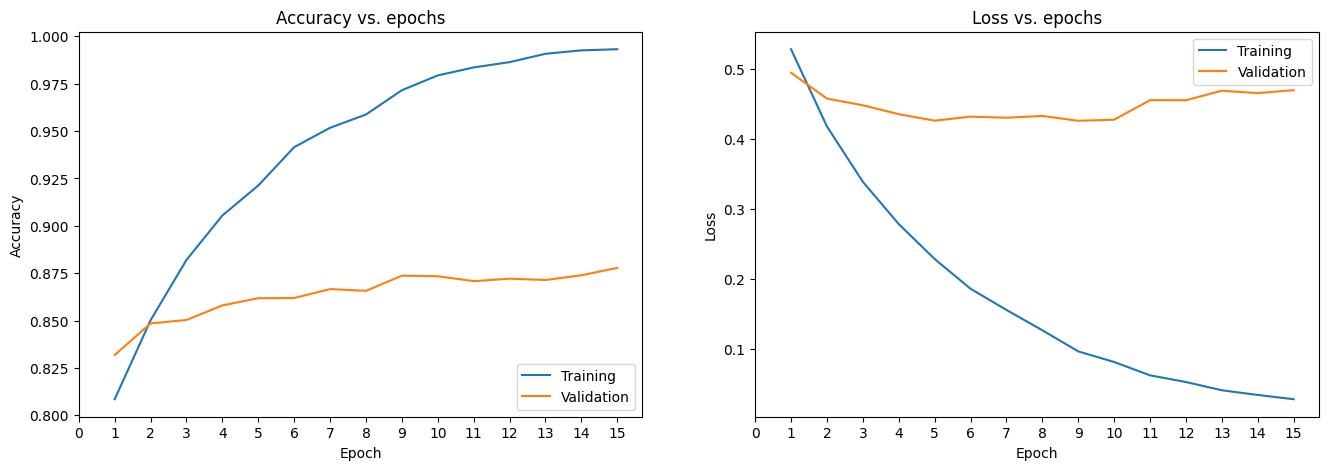

2022-08-16 09:52:57,340: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 10s 33ms/step


2022-08-16 09:53:36,017: INFO: test loss:0.4696
2022-08-16 09:53:36,017: INFO: test accuracy:0.8778
2022-08-16 09:53:36,022: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:53:36,025: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:53:36,025: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:53:36,027: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:53:36,028: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:53:38,187: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator


313/313 [==============================] - 2s 4ms/step


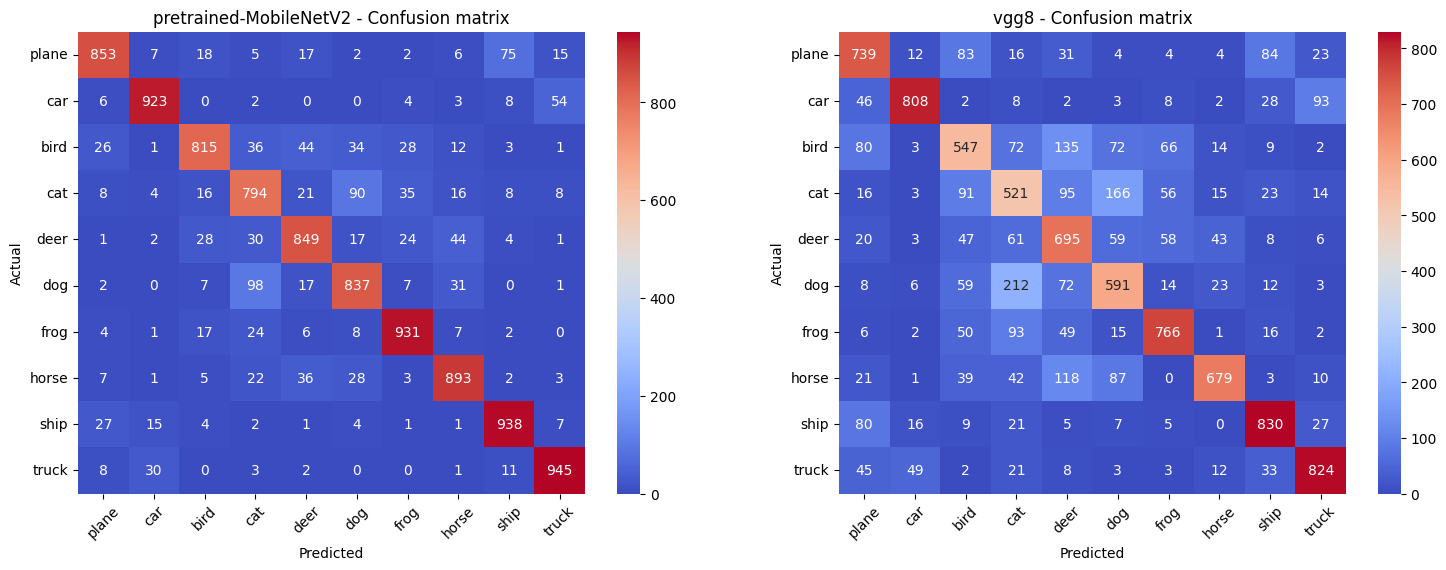

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_500.ipynb        1874250   
2                    vgg8  cifar10_0816_cnt_500.ipynb        1672906   
3                 custom1  cifar10_0816_cnt_500.ipynb          73738   
4            resnet_v1_20  cifar10_0816_cnt_500.ipynb         273066   
5                  lenet1  cifar10_0816_cnt_500.ipynb          83170   
6                    mlp1  cifar10_0816_cnt_500.ipynb         394634   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1       487.0  2022-08-16 09:53      0.0125     0.4696          0.9992   
2       497.7  2022-08-16 09:10      0.0072     1.6269          0.9992   
3       218.9  2022-08-16 09:01      0.0772     1.4183          0.9882   
4       872.3  2022-08-16 09:25      0.3798     1.6719          0.9262   
5       175.9  2022-08-16 08:58      0.2076     1.6151          0.9548   
6       103.6  2022-08-16 08:55      1.3138     1.7759          0.5434   

   test_accuracy  train_auc  test_auc  
1         0.8778     1.0000    0.9906  
2         0.7000     1.0000    0.9473  
3         0.6246     0.9998    0.9292  
4         0.5357     0.9967    0.8983  
5         0.5340     0.9985    0.8930  
6         0.3826     0.9025    0.8128

In [49]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [50]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-16 09:53:53,104: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-16 09:53:53,106: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 09:53:53,107: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 09:53:53,108: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:53:53,110: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:53:53,111: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

model_name                 program_name  weight_number  \
1   pretrained-MobileNetV2  cifar10_0816_cnt_1000.ipynb        1874250   
2   pretrained-MobileNetV2   cifar10_0816_cnt_500.ipynb        1874250   
3   pretrained-MobileNetV2   cifar10_0816_cnt_100.ipynb        1874250   
4                     vgg8  cifar10_0816_cnt_1000.ipynb        1672906   
5                     vgg8   cifar10_0816_cnt_500.ipynb        1672906   
6                  custom1  cifar10_0816_cnt_1000.ipynb          73738   
7             resnet_v1_20  cifar10_0816_cnt_1000.ipynb         273066   
8                  custom1   cifar10_0816_cnt_500.ipynb          73738   
9                   lenet1  cifar10_0816_cnt_1000.ipynb          83170   
10                    vgg8   cifar10_0816_cnt_200.ipynb        1672906   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1        598.4  2022-08-16 09:26      0.0212     0.4112          0.9963   
2        487.0  2022-08-16 09:53      0.0125     0.4696          0.9992   
3        399.4  2022-08-16 09:37      0.0413     0.6508          0.9950   
4        435.9  2022-08-16 08:46      0.0137     1.3588          0.9992   
5        497.7  2022-08-16 09:10      0.0072     1.6269          0.9992   
6        246.7  2022-08-16 08:38      0.1393     1.0998          0.9655   
7        863.5  2022-08-16 09:01      0.1716     2.1340          0.9992   
8        218.9  2022-08-16 09:01      0.0772     1.4183          0.9882   
9        209.3  2022-08-16 08:34      0.1788     1.3058          0.9571   
10       407.1  2022-08-16 09:10      0.0139     1.9241          0.9970   

    test_accuracy  train_auc  test_auc  
1          0.8930     1.0000    0.9929  
2          0.8778     1.0000    0.9906  
3          0.8021     0.9999    0.9788  
4          0.7527     1.0000    0.9586  
5          0.7000     1.0000    0.9473  
6          0.6844     0.9991    0.9487  
7          0.6399     1.0000    0.9294  
8          0.6246     0.9998    0.9292  
9          0.6176     0.9988    0.9271  
10         0.6089     1.0000    0.9188

In [51]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-16 09:53:53,190: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2
2022-08-16 09:54:03,887: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 09:54:03,911: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/pretrained-MobileNetV2
2022-08-16 09:54:15,206: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/default.generator
2022-08-16 09:54:15,222: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2
2022-08-16 09:54:25,803: INFO: loading generator from /

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 1s 1s/step


2022-08-16 09:54:35,181: WARNING: 5 out of the last 317 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7faba59ab790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 416ms/step


2022-08-16 09:54:35,432: WARNING: 6 out of the last 318 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fabd01b08b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


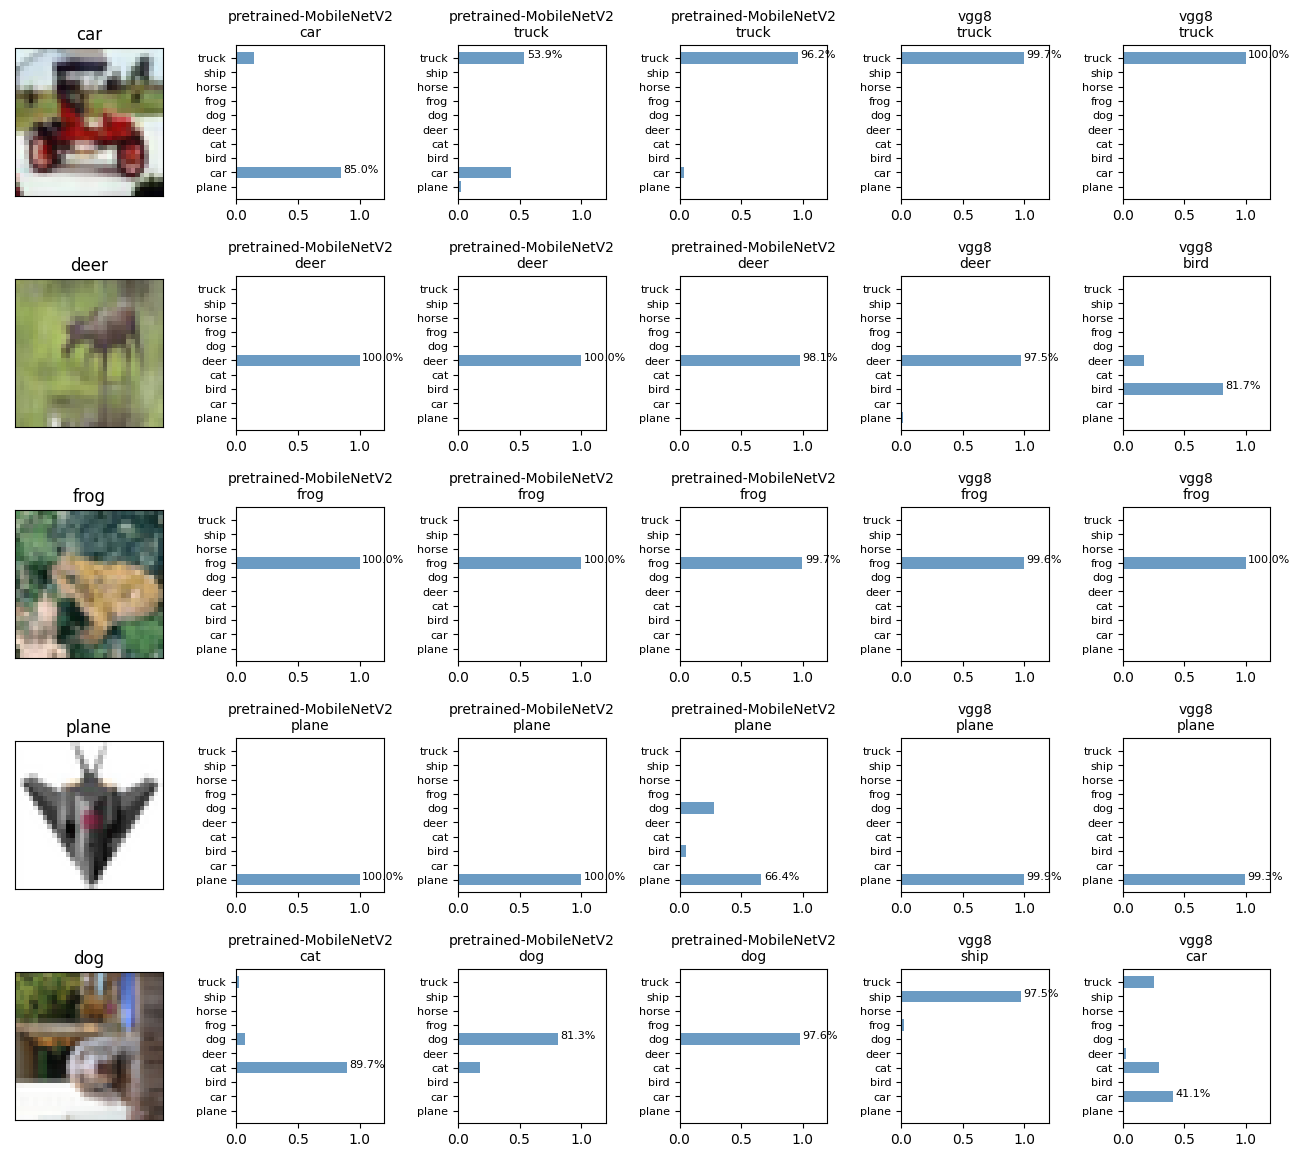

In [52]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 11ms/step


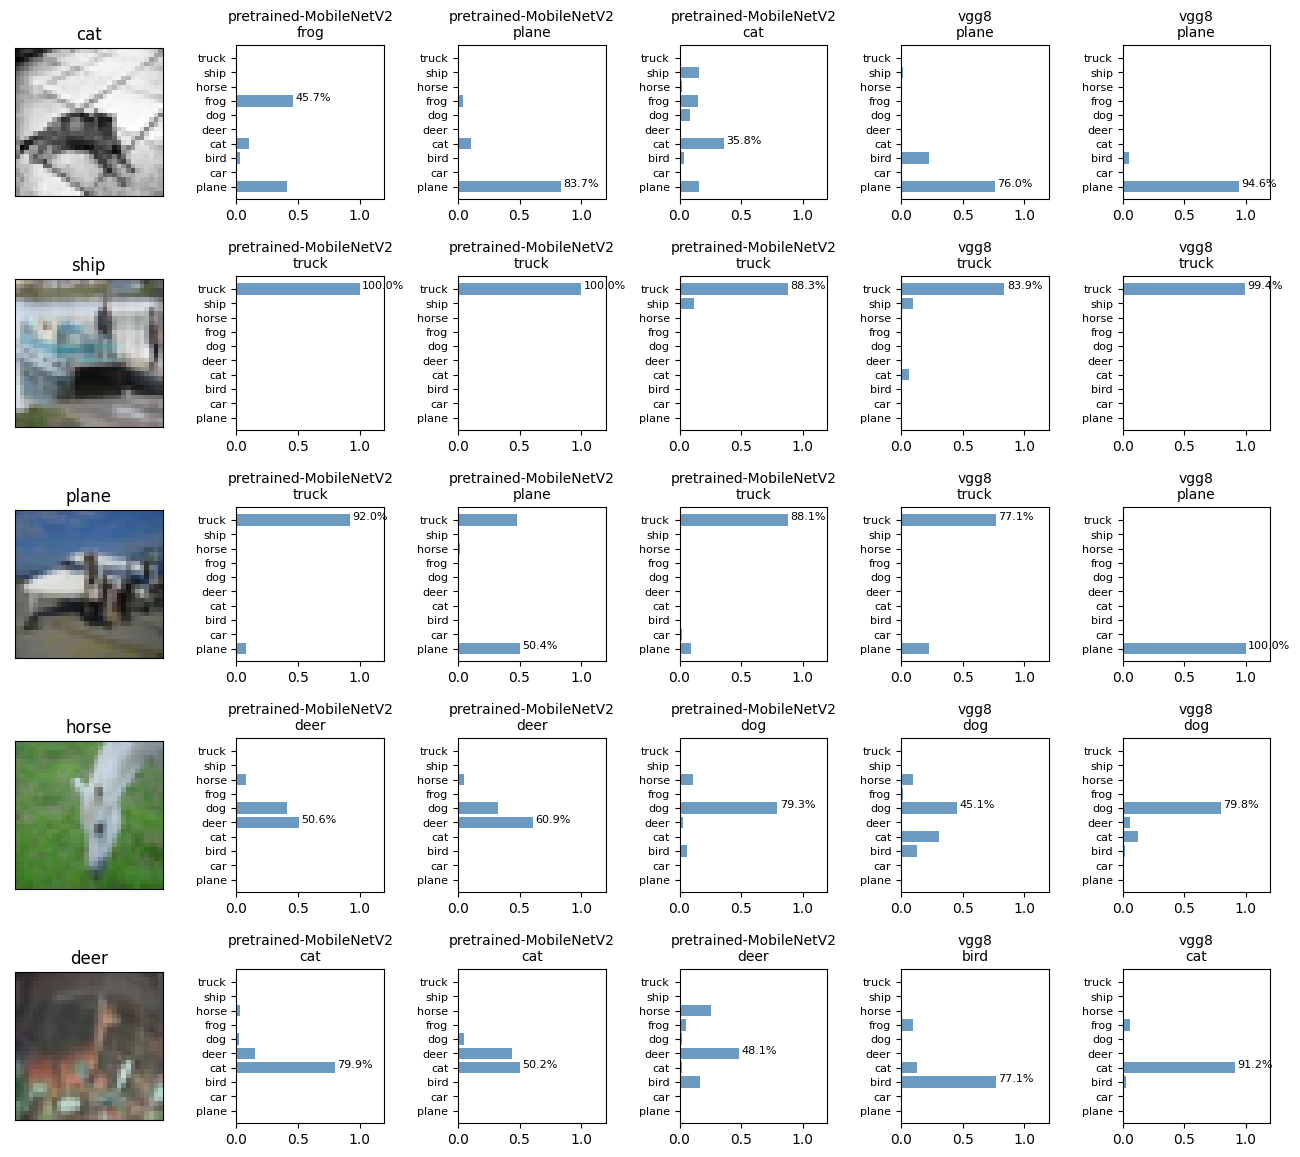

In [53]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [54]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.41117557883262634, 'accuracy': 0.8930000066757202, 'mae': 10.240538597106934}
313/313 [==============================] - 7s 23ms/step
(10000, 10)


In [55]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 8s 25ms/step


precision  recall        f1
plane   0.890078   0.915  0.902367
car     0.960622   0.927  0.943511
bird    0.918015   0.851  0.883238
cat     0.827214   0.766  0.795431
deer    0.885093   0.855  0.869786
dog     0.831395   0.858  0.844488
frog    0.894286   0.939  0.916098
horse   0.875947   0.925  0.899805
ship    0.945122   0.930  0.937500
truck   0.904315   0.964  0.933204

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.8901    0.9150    0.9024      1000
         car     0.9606    0.9270    0.9435      1000
        bird     0.9180    0.8510    0.8832      1000
         cat     0.8272    0.7660    0.7954      1000
        deer     0.8851    0.8550    0.8698      1000
         dog     0.8314    0.8580    0.8445      1000
        frog     0.8943    0.9390    0.9161      1000
       horse     0.8759    0.9250    0.8998      1000
        ship     0.9451    0.9300    0.9375      1000
       truck     0.9043    0.9640    0.9332      1000

    accuracy                         0.8930     10000
   macro avg     0.8932    0.8930    0.8925     10000
weighted avg     0.8932    0.8930    0.8925     10000



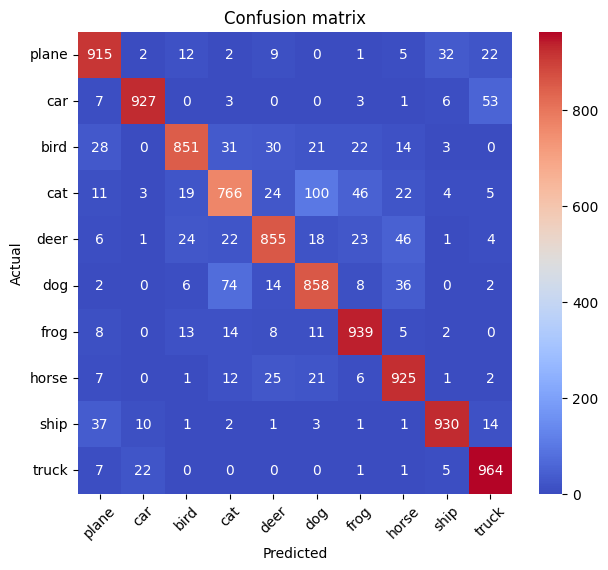

In [56]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)